# Assignment 1

Discussion Notes:
* Whiskey vs Non-Whiskey (Classification) to be used
* 400K dataset to be used  

Next steps:
* Clean up business understanding
* jeff to put images of barplots of entire dataset within exceptional work
* review/edit write up regarding classification within business rule
* run and clean up code within each section
* add any necessary verbiage for each image

Todo:
* provide a bar chart showing the months represented in the dataset (in visualizations). can include something like sales in the month
* make sure we are answering each quesiton in the rubric in the respective section, so move our outliers discussion and how we addressed them into the data quality section
* provide a few additional visualizations on whiskies
* possibly get a tableau visual of iowa zip codes and whiskies
* do an LDA on whiskey in the exceptional section (dan can work on)

### Business Understanding

Introduction - The Iowa Liquor Sales dataset is an API from Google’s Bigquery which contains the wholesale purchases by retail stores in the Iowa area.  The dataset includes the spirit purchase details by product, date of purchase, and location the item was purchased from an Iowa Class “E” liquor license holder (retail stores) . The timeframe of this data starts from January 1, 2012 through 2019. As part of the study commissioned by the Iowa Department of Commerce, all alcoholic sales within the state were logged into the Department system, and in turn, published as open data by the State of Iowa. The dataset contains detail on the name, product, quantity and location of the individual container or package sale between the wholesaler (vendor) and the retailer.  

1. Set Objectives: We are a new and emerging Whisky brand who specializes in single-malt Rye, and we have targeted the state of Iowa for our next brand expansion. Before doing so, our goal will be to identify and predict which markets are more likely to sell greater volumes of whiskey, so that we can more efficiently spend our marketing dollars and inventory with little waste or buyback. Related questions also include, which brands are going to sell the most in each market, what parts of the year are going to have higher whiskey sales as opposed to lower whiskey sales to optimize advertising dollars, and what features of a town are defining characteristics of a large whiskey seller. 

2. Product Project Plan: To meet our goals, we will first use the Google Bigquery API to access the publicly available Iowa Liquor Sales data via python and Jupyter Notebook. Since the dataset is over 17 million lines of data, we will focus just on 2 months worth of data to do the cleaning. From here, we will define a subset to grant us 30,000 observations, address missing values and begin to build models that could help us answer questions based on markets likely to sell more whiskey. For our data on times of the year when we will sell more whiskey, we will need to create a subset of a full year’s data to build a time series model. For the town features, we will need to include additional information about the zip codes of iowa (such as population, income, ect) to get more demographic detail on each market to assist with a program for a clustering problem. For each of these problems, we will create a training and testing data set to help tune our predictions. 

3. Business Success Criteria - For our prediction models of market sales, we will be consider our model successful if we are able to classify our alochol type with a strong precision, recall and accuracy using a cross validation. Ideally, if we are dealing with 5 alcohol types, we will want to be able to predict whiskey accurately over 20% of the time. 

From the sale price prediction problem, we will run a linear regression technique against the remaining features. For this technique, we will use Root Mean Square Error to evaluate the effectiveness. A strong criteria for performance would be if we can get within $3 as an RMSE.

Joe's thoughts for classification -  
 - Logistic Margin above or below a certain point. e.g. sales retail / costs > 35%

## Data Meaning Type

The initial data set is 4.63GB with 17.7 million rows.  This was too large for our systems to handle, so we took a subset of the data.  Please refer to the Exception Work on how we analyzed the full data set, which included a combination of BigQuery queries, and visualizing that data in order to come up with our subset which we saved as a csv file in our github repository

### Load Python Packages

In [0]:
# Import necessary python packages
try:
    from collections import abc as collections_abc
except ImportError:  # Python 2.7
    import collections as collections_abc

    import copy
import functools
import gzip
import io
import itertools
import json
import math
import os
import tempfile
import uuid
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import numpy as np
#import altair as alt
import matplotlib.pyplot as plt
import re

# Imports the Google Cloud client library
#from google.cloud import storage
from google.oauth2 import service_account
from google.cloud import bigquery

### Load Data from github

For our measurement, we will be querying the 2019 and limiting the rows to 
50,000 for our intial modeling, which we can later expand to see how our model translates to scale.

In [12]:
# Read csv from disk
#df =  pd.read_csv(r'/Users/jjschued/Documents/Github/7331DataMiningNotebooks/lab1/iowa_subset_2019_400k_random_rows.csv', nrows = 50000)
#df =  pd.read_csv(r'/Users/danielclark/Desktop/SMU/data_mining/7331DataMiningNotebooks/lab1/iowa_subset_2019_400k_random_rows.csv', nrows = 50000)

# read csv from github directly
url = 'https://github.com/jjschueder/7331DataMiningNotebooks/blob/master/lab1/iowa_subset_2019_400k_random_rows.csv?raw=true'
df = pd.read_csv(url, nrows=50000)

# verify data read in
print(df.head(5))

  invoice_and_item_number        date  ...  volume_sold_liters volume_sold_gallons
0         INV-23084400002  2019-11-07  ...                7.50                1.98
1         INV-23282200001  2019-11-18  ...                0.05                0.01
2         INV-19435800130  2019-05-17  ...                6.00                1.58
3         INV-23454200002  2019-11-25  ...               18.00                4.75
4         INV-23541200001  2019-11-27  ...               21.00                5.54

[5 rows x 24 columns]


### Columns and Descriptions

Below are the 24 columns found in the data set along with description of each 

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 24 columns):
invoice_and_item_number    50000 non-null object
date                       50000 non-null object
store_number               50000 non-null int64
store_name                 50000 non-null object
address                    49915 non-null object
city                       49915 non-null object
zip_code                   49915 non-null float64
store_location             45182 non-null object
county_number              49915 non-null float64
county                     49915 non-null object
category                   49831 non-null float64
category_name              49831 non-null object
vendor_number              50000 non-null int64
vendor_name                50000 non-null object
item_number                50000 non-null int64
item_description           50000 non-null object
pack                       50000 non-null int64
bottle_volume_ml           50000 non-null int64
state_bottl

Detailed Description of each field

*   invoice_and_item_number (text) - Invoice and item associated with the liquor order.  This is unique identifier 
*   date (date) - Date of when the order was placed
*   store_number (int) - Unique number assigned to the retail store that placed the order
*   store_name (text) - Name of the retail store that placed the order
*   address (text) - Address of the retail store that placed the order
*   city (text) - City of the retail store that placed the order
*   zip_code (float) - Zip code of the retail store that placed the order
*   store_location (text) - Lat/Long of retail store that placed the order
*   county_number (float) - Iowa county number for which the retail store that placed the order resides
*   county (text) - County name for which the retail store is located that placed the order
*   category (float) - Category code for the liquor that was ordered
*   category_name (text) - Category of the liquor that was ordered
*   vendor_number (int) - The vendor number of the company for the brand of liquor ordered 
*   vendor_name (text) - The vendor name of the company for the brand of liquor ordered
*   item_number (int) - Item number for individual liquor product ordered
*   item_description (text) - Description of the liquor item ordered
*   pack (int) - The number of bottles in a case for the liquor ordered
*   bottle_volume_ml (int) - Volume of each liquor bottle ordered in milliliters
*   state_bottle_cost (float) - The amount that Alcoholic Beverages Division paid for each bottle of liquor ordered
*   state_bottle_retail (float) - The amount the store paid for each bottle of liquor ordered
*   bottles_sold (int) - Number of bottles of liquor ordered by the retail store
*   sale_dollars (float) - Total cost of liquor ordered (bottles_sold * state_bottle_retail)
*   volume_sold_liters (float) - Total volume of liquor ordered in liters (bottle_volume_ml * bottles_sold / 1000)
*   volume_sold_gallons (float) - Total volume of liquor ordered in gallons (bottle_volume_ml * bottles_sold / 3785.411784)





## Data Quality

In [0]:
df.info

<bound method DataFrame.info of       invoice_and_item_number        date  store_number  \
0             INV-23084400002  2019-11-07          3869   
1             INV-23282200001  2019-11-18          4617   
2             INV-19435800130  2019-05-17          2560   
3             INV-23454200002  2019-11-25          2614   
4             INV-23541200001  2019-11-27          2629   
...                       ...         ...           ...   
49995         INV-17241000143  2019-01-30          2616   
49996         INV-17382700010  2019-02-06          2548   
49997         INV-20839900001  2019-07-25          4509   
49998         INV-17608900026  2019-02-18          2575   
49999         INV-21188000001  2019-08-13          2535   

                                   store_name                     address  \
0                   Bootleggin' Barzini's Fin                412  1st Ave   
1                              Lickety Liquor            2501 HUBBELL AVE   
2                  Hy-Vee Fo

In [0]:
#df.to_csv(index=False)

In [0]:
df.columns.values

array(['invoice_and_item_number', 'date', 'store_number', 'store_name',
       'address', 'city', 'zip_code', 'store_location', 'county_number',
       'county', 'category', 'category_name', 'vendor_number',
       'vendor_name', 'item_number', 'item_description', 'pack',
       'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail',
       'bottles_sold', 'sale_dollars', 'volume_sold_liters',
       'volume_sold_gallons'], dtype=object)

Running a df.columns.values function, confirms the 24 features that we referenced in our Data understanding phase. This now allows us to move forward with our data cleaning. 

### Data Cleaning

In our data cleaning step, we need to perform a few specific data cleaning operations. 1.) We will need to convert our features to the correct continuous, ordinal and categorical features, and 2.) we will need to address the missing values. 3.) We will want to create a category that simplifies our alcohol categories to specific genres like whiskey, vodka, tequilla, ect. 4.) We will also want to categorize our store locations into a few easily discernable buckets. 5.) Create a month and date column for opportunities to time and date analysis

To begin the process of addressing missing values so that we can convert our data types, we will replace all "?", which our dataset denotes as null, into "-1" values (not strings). From here, we will convert state_bottle_cost, state_bottle_retail, sale_dollars, volume_sold_liters, and volume_sold_gallons into continuous variables so they register as floats. 


In addition, we will need to convert the varaible "bottles_sold" into ordinal features so they register as an integer value in our models. 

Thirdly, we will want to replace the values for pack, bottle_volume_ml, store_number, store_name, address, city, zip_code, county_number, county, category, category_name, vendor_number, vendor_name, item_number and item_description into categorical variables so they register as a non-null object in our model.

Using a df.info function helps to verify this. 

The following will do some cleanup on values and categorize store, category, and dates into more summarized values

In [0]:
df.dtypes

invoice_and_item_number     object
date                        object
store_number                 int64
store_name                  object
address                     object
city                        object
zip_code                   float64
store_location              object
county_number              float64
county                      object
category                   float64
category_name               object
vendor_number                int64
vendor_name                 object
item_number                  int64
item_description            object
pack                         int64
bottle_volume_ml             int64
state_bottle_cost          float64
state_bottle_retail        float64
bottles_sold                 int64
sale_dollars               float64
volume_sold_liters         float64
volume_sold_gallons        float64
dtype: object

In [0]:
#upper case category name for matching later
df['category_name'] = df['category_name'].str.upper()

In [0]:
df['category_name'][40:45]

40    TEMPORARY & SPECIALTY PACKAGES
41    TEMPORARY & SPECIALTY PACKAGES
42                        TRIPLE SEC
43                 IMPORTED DRY GINS
44                 IMPORTED DRY GINS
Name: category_name, dtype: object

In [0]:
#convert nan to blanks
df = (df.replace(r'^\s*$', np.nan, regex=True))

In [0]:
df = (df.replace(np.nan, 'blank', regex=True))

In [0]:
#download to categorize in more summarized manner
#liquortcatlistdf.to_csv("C:\\Users\\jjsch\\downloads\\liquorcats.csv")    
#import the file
#liquortcatlistdf = pd.read_csv("C:\\Users\\jjsch\\downloads\\liquorcats.csv")
#liquortcatlistdf = pd.read_csv("C:\\Users\\jjschued\\Documents\\SMU\\7331 Machine Learning\\Github\\7331DataMiningNotebooks\\liquorcats.csv")
#liquortcatlistdf.dtypes

#grouping all the store locations into parent stores
df['Category'] = 'Other'
df.loc[df['category_name'].str.contains('GINS'), 'Category'] = 'GIN'
df.loc[df['category_name'].str.contains('GINS'), 'Category'] = 'GIN'
df.loc[df['category_name'].str.contains('GIN'), 'Category'] = 'GIN'
df.loc[df['category_name'].str.contains('RUMS'), 'Category'] = 'RUM'
df.loc[df['category_name'].str.contains('RUM'), 'Category'] = 'RUM'
df.loc[df['category_name'].str.contains('SCOTCH'), 'Category'] = 'WHISKY'
df.loc[df['category_name'].str.contains('WHISKIES'), 'Category'] = 'WHISKY'
df.loc[df['category_name'].str.contains('WHISKY'), 'Category'] = 'WHISKY'
df.loc[df['category_name'].str.contains('WHISKEY'), 'Category'] = 'WHISKY'
df.loc[df['category_name'].str.contains('RYE'), 'Category'] = 'WHISKY'
df.loc[df['category_name'].str.contains('AMARETTO'), 'Category'] = 'AMARETTO'
df.loc[df['category_name'].str.contains('BOURBON'), 'Category'] = 'WHISKY'
df.loc[df['category_name'].str.contains('LIQUEURS'), 'Category'] = 'LIQUEUR'
df.loc[df['category_name'].str.contains('LIQUEUR'), 'Category'] = 'LIQUEUR'
df.loc[df['category_name'].str.contains('VODKAS'), 'Category'] = 'VODKA'
df.loc[df['category_name'].str.contains('VODKA'), 'Category'] = 'VODKA'
df.loc[df['category_name'].str.contains('BRANDY'), 'Category'] = 'BRANDY'
df.loc[df['category_name'].str.contains('BRANDIES'), 'Category'] = 'GIN'
df.loc[df['category_name'].str.contains('CREME'), 'Category'] = 'SCHNAPPS'
df.loc[df['category_name'].str.contains('SCHNAPPS'), 'Category'] = 'SCHNAPPS'
df.loc[df['category_name'].str.contains('TEQUILA'), 'Category'] = 'TEQUILA'
df.loc[df['category_name'].str.contains('TEQUILAS'), 'Category'] = 'TEQUILA'




In [0]:
#get a few stray not available categories per internet this is tequila
df.loc[df['item_description'] == 'Herradura Gold Reposado 6pak', 'Category'] = "Tequila"
df.loc[df['item_description'] == 'Chambord Liqueur w/2 Glasses', 'Category'] = "Liquers"

#grouping all the store locations into parent stores
df['store_parent'] = 'Other'
df.loc[df['store_name'].str.contains('Hy-Vee'), 'store_parent'] = 'Hy-Vee'
df.loc[df['store_name'].str.contains('Wal-Mart'), 'store_parent'] = 'Wal-Mart'
df.loc[df['store_name'].str.contains('SamsClub'), 'store_parent'] = 'SamsClub'
df.loc[df['store_name'].str.contains('Fareway'), 'store_parent'] = 'Fareway'
df.loc[df['store_name'].str.contains('Kum&Go'), 'store_parent'] = 'Kum&Go'
df.loc[df['store_name'].str.contains('CVS'), 'store_parent'] = 'CVS'
df.loc[df['store_name'].str.contains('Target'), 'store_parent'] = 'Target'
df.loc[df['store_name'].str.contains('Caseys'), 'store_parent'] = 'Caseys'
df.loc[df['store_name'].str.contains('Dahls'), 'store_parent'] = 'Dahls'
df.loc[df['store_name'].str.contains('WAL-MART'), 'store_parent'] = 'Wal-Mart'
df.loc[df['store_name'].str.contains('HY-VEE'), 'store_parent'] = 'Hy-Vee'
df.loc[df['store_name'].str.contains('KUM&GO'), 'store_parent'] = 'Kum&Go'
df.loc[df['store_name'].str.contains('QuikTrip'), 'store_parent'] = 'QuikTrip'


#labored conversion of dates to month year and month year by converting to strings
df['month'] = pd.DatetimeIndex(df['date']).month
df['year'] = pd.DatetimeIndex(df['date']).year

df.loc[df['month'] ==1 , 'month'] = 'Jan'
df.loc[df['month'] ==2 , 'month'] = 'Feb'
df.loc[df['month'] ==3 , 'month'] = 'Mar'
df.loc[df['month'] ==4 , 'month'] = 'Apr'
df.loc[df['month'] ==5 , 'month'] = 'May'
df.loc[df['month'] ==6 , 'month'] = 'Jun'
df.loc[df['month'] ==7 , 'month'] = 'Jul'
df.loc[df['month'] ==8 , 'month'] = 'Aug'
df.loc[df['month'] ==9 , 'month'] = 'Sep'
df.loc[df['month'] ==10 , 'month'] = 'Oct'
df.loc[df['month'] ==11 , 'month'] = 'Nov'
df.loc[df['month'] ==12 , 'month'] = 'Dec'


df.loc[df['year'] ==2012 , 'year'] = '2012'
df.loc[df['year'] ==2013 , 'year'] = '2013'
df.loc[df['year'] ==2014 , 'year'] = '2014'
df.loc[df['year'] ==2015 , 'year'] = '2015'
df.loc[df['year'] ==2016 , 'year'] = '2016'
df.loc[df['year'] ==2017 , 'year'] = '2017'
df.loc[df['year'] ==2018 , 'year'] = '2018'
df.loc[df['year'] ==2019 , 'year'] = '2019'

#merge year and month together
df['monthyear'] = df['month'] + "-" + df['year']

In [0]:
df.head(20)

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,Category,store_parent,month,year,monthyear
0,INV-23084400002,2019-11-07,3869,Bootleggin' Barzini's Fin,412 1st Ave,Coralville,52241,POINT (-91.565517 41.672672),52,JOHNSON,...,5.78,20,115.60,7.50,1.98,Other,Other,Nov,2019,Nov-2019
1,INV-23282200001,2019-11-18,4617,Lickety Liquor,2501 HUBBELL AVE,Des Moines,50317,POINT (-93.570489 41.607817),77,POLK,...,13.13,1,13.13,0.05,0.01,Other,Other,Nov,2019,Nov-2019
2,INV-19435800130,2019-05-17,2560,Hy-Vee Food Store / Marion,3600 Business Hwy 151 East,Marion,52302,blank,57,LINN,...,24.75,6,148.50,6.00,1.58,GIN,Hy-Vee,May,2019,May-2019
3,INV-23454200002,2019-11-25,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,...,31.76,24,762.24,18.00,4.75,WHISKY,Hy-Vee,Nov,2019,Nov-2019
4,INV-23541200001,2019-11-27,2629,Hy-Vee Food Store #2 / Council Bluffs,1745 Madison Ave,Council Bluffs,51503,POINT (-95.825137 41.242732),78,POTTAWATTA,...,13.97,12,167.64,21.00,5.54,Other,Hy-Vee,Nov,2019,Nov-2019
5,INV-23540300028,2019-11-27,4312,I-80 Liquor / Council Bluffs,2411 S 24TH ST #1,Council Bluffs,51501,POINT (-95.8792 41.238092),78,POTTAWATTA,...,43.47,6,260.82,6.00,1.58,WHISKY,Other,Nov,2019,Nov-2019
6,INV-19655400089,2019-05-29,2517,Hy-Vee Food Store #1 / Newton,1501 First Avenue East,Newton,50208,POINT (-93.034296 41.69916),50,JASPER,...,7.35,12,88.20,6.00,1.58,Other,Hy-Vee,May,2019,May-2019
7,INV-23687700099,2019-12-05,2545,Hy-Vee Drugstore / Iowa City,310 N 1st St,Iowa City,52245,POINT (-91.528105 42.207428),52,JOHNSON,...,12.75,30,382.50,22.50,5.94,Other,Hy-Vee,Dec,2019,Dec-2019
8,INV-17141800065,2019-01-25,5210,Ding's Honk'n Holler,"900, E Washington St",Clarinda,51632,POINT (-95.027238 40.739231),73,PAGE,...,13.13,2,26.26,0.60,0.15,Other,Other,Jan,2019,Jan-2019
9,INV-23109300014,2019-11-08,5411,Bluejay Market,2810 Wills Ave,Perry,50220,POINT (-94.081127 41.838488),25,DALLAS,...,50.01,6,300.06,6.00,1.58,Other,Other,Nov,2019,Nov-2019


At the far right of the above dataset, you can see the 5 new columns we created and thier respective values. 

In [0]:
import numpy as np
# replace '?' with -1, we will deal with missing values later
df = df.replace(to_replace='?',value=-1) 

categorical_features = ['city', 'county',  'category_name','vendor_name', 'store_number', 'item_description','store_parent', 
                        'monthyear', 'Category', 'county_number', 'vendor_number', 'item_number']

# let's start by first changing the numeric values to be floats
continuous_features = ['state_bottle_cost', 'state_bottle_retail', 'sale_dollars', 'volume_sold_liters', 'volume_sold_gallons', 'bottles_sold']

# and the oridnal values to be integers
ordinal_features = ['pack', 'bottle_volume_ml']

# use the "astype" function to change the variable type
df[continuous_features] = df[continuous_features].astype(np.float64)
df[ordinal_features] = df[ordinal_features].astype(np.int64)
df[categorical_features] = df[categorical_features].astype(object)
df.info() # now our data looks better!!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 29 columns):
invoice_and_item_number    50000 non-null object
date                       50000 non-null object
store_number               50000 non-null object
store_name                 50000 non-null object
address                    50000 non-null object
city                       50000 non-null object
zip_code                   50000 non-null object
store_location             50000 non-null object
county_number              50000 non-null object
county                     50000 non-null object
category                   50000 non-null object
category_name              50000 non-null object
vendor_number              50000 non-null object
vendor_name                50000 non-null object
item_number                50000 non-null object
item_description           50000 non-null object
pack                       50000 non-null int64
bottle_volume_ml           50000 non-null int64
state_bottl

In [0]:
dfstats = df.describe() # will get summary of continuous or the nominals

# let's set those values to NaN, so that Pandas understand they are missing
df = df.replace(to_replace=-1,value=np.nan) # replace -1 with NaN (not a number)
print (df.info())
df[categorical_features] = df[categorical_features].astype(object)
dfstats2 = df.describe() # scroll over to see the values

categorical_features = ['city', 'county',  'category_name','vendor_name', 'store_number', 'item_description','store_parent', 
                        'monthyear', 'Category', 'county_number', 'vendor_number', 'item_number']

# let's start by first changing the numeric values to be floats
continuous_features = ['state_bottle_cost', 'state_bottle_retail', 'sale_dollars', 'volume_sold_liters', 'volume_sold_gallons', 'bottles_sold']

# and the oridnal values to be integers
ordinal_features = ['pack', 'bottle_volume_ml']

# use the "astype" function to change the variable type
df[continuous_features] = df[continuous_features].astype(np.float64)
df[ordinal_features] = df[ordinal_features].astype(np.int64)
df[categorical_features] = df[categorical_features].astype(object)
df['store_number'] = df['store_number'].astype(object)
df.info() # now our data looks better!!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 29 columns):
invoice_and_item_number    50000 non-null object
date                       50000 non-null object
store_number               50000 non-null int64
store_name                 50000 non-null object
address                    50000 non-null object
city                       50000 non-null object
zip_code                   50000 non-null object
store_location             50000 non-null object
county_number              50000 non-null object
county                     50000 non-null object
category                   50000 non-null object
category_name              50000 non-null object
vendor_number              50000 non-null int64
vendor_name                50000 non-null object
item_number                50000 non-null int64
item_description           50000 non-null object
pack                       50000 non-null int64
bottle_volume_ml           50000 non-null int64
state_bottle_c

Here, you can see that our cleaning has addressed all nulls down to zero so we can begin analysis. The count code below helps to show that there is zero nulls in our dataset.

In [0]:
dfna = df[df.isna().any(axis=1)]
dfna.isna().sum()

invoice_and_item_number    0
date                       0
store_number               0
store_name                 0
address                    0
city                       0
zip_code                   0
store_location             0
county_number              0
county                     0
category                   0
category_name              0
vendor_number              0
vendor_name                0
item_number                0
item_description           0
pack                       0
bottle_volume_ml           0
state_bottle_cost          0
state_bottle_retail        0
bottles_sold               0
sale_dollars               0
volume_sold_liters         0
volume_sold_gallons        0
Category                   0
store_parent               0
month                      0
year                       0
monthyear                  0
dtype: int64

The next task will be for us to look into our categorical features with over 30 unique values, and we will be dropping any columns that have more than 30 uniques. The reason we are doing this is that we will ultimately have trouble with our predictions as these values will likely ultimately have unique attributes to a specific combination of observations. 

In [0]:
#Unique Value Threshold (Per Column)
#Delete Columns >  uniqueThreshold unique values prior to one-hot encoding. 
#(each unique value becomes a new column during one-hot encoding)
uniqueThreshold = 30
# in each column of dataframe
uniqueValues = df.nunique()
uniqueValues

invoice_and_item_number    50000
date                         263
store_number                1626
store_name                  1634
address                     1626
city                         409
zip_code                     443
store_location              1500
county_number                100
county                       129
category                      40
category_name                 40
vendor_number                112
vendor_name                  113
item_number                 1180
item_description            1149
pack                          15
bottle_volume_ml              22
state_bottle_cost            651
state_bottle_retail          651
bottles_sold                 100
sale_dollars                3407
volume_sold_liters           211
volume_sold_gallons          210
Category                       7
store_parent                   6
month                         12
year                           1
monthyear                     12
dtype: int64

In [0]:
#Isolate continuous and categorical data types
#These are indexers into the schoolData dataframe and may be used similar to the schoolData dataframe 
D_boolean = df.loc[:, (df.dtypes == bool) ]
D_nominal = df.loc[:, (df.dtypes == object)]
D_continuous = df.loc[:, (df.dtypes != bool) & (df.dtypes != object)]
print ("Boolean Columns: ", D_boolean.shape[1])
print ("Nominal Columns: ", D_nominal.shape[1])
print ("Continuous Columns: ", D_continuous.shape[1])
print ("Columns Accounted for: ", D_nominal.shape[1] + D_continuous.shape[1] + D_boolean.shape[1])

Boolean Columns:  0
Nominal Columns:  21
Continuous Columns:  8
Columns Accounted for:  29


In [0]:
#Delete categorical columns with > 30 unique values (Each unique value becomes a column during one-hot encoding)
oneHotUniqueValueCounts = df[D_nominal.columns].apply(lambda x: x.nunique())
oneHotUniqueValueCols = oneHotUniqueValueCounts[oneHotUniqueValueCounts >= uniqueThreshold].index

In [0]:
oneHotUniqueValueCounts
oneHotUniqueValueCols

Index(['invoice_and_item_number', 'date', 'store_number', 'store_name',
       'address', 'city', 'zip_code', 'store_location', 'county_number',
       'county', 'category', 'category_name', 'vendor_number', 'vendor_name',
       'item_number', 'item_description'],
      dtype='object')

In [0]:
oneHotUniqueValueCols

Index(['invoice_and_item_number', 'date', 'store_number', 'store_name',
       'address', 'city', 'zip_code', 'store_location', 'county_number',
       'county', 'category', 'category_name', 'vendor_number', 'vendor_name',
       'item_number', 'item_description'],
      dtype='object')

In [0]:
onehotlist = oneHotUniqueValueCols.tolist()
onehotlist

['invoice_and_item_number',
 'date',
 'store_number',
 'store_name',
 'address',
 'city',
 'zip_code',
 'store_location',
 'county_number',
 'county',
 'category',
 'category_name',
 'vendor_number',
 'vendor_name',
 'item_number',
 'item_description']

In [0]:
#one hot encoding
dfenc = df.copy()
dfenc

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,Category,store_parent,month,year,monthyear
0,INV-23084400002,2019-11-07,3869,Bootleggin' Barzini's Fin,412 1st Ave,Coralville,52241,POINT (-91.565517 41.672672),52,JOHNSON,...,5.78,20.0,115.60,7.50,1.98,Other,Other,Nov,2019,Nov-2019
1,INV-23282200001,2019-11-18,4617,Lickety Liquor,2501 HUBBELL AVE,Des Moines,50317,POINT (-93.570489 41.607817),77,POLK,...,13.13,1.0,13.13,0.05,0.01,Other,Other,Nov,2019,Nov-2019
2,INV-19435800130,2019-05-17,2560,Hy-Vee Food Store / Marion,3600 Business Hwy 151 East,Marion,52302,blank,57,LINN,...,24.75,6.0,148.50,6.00,1.58,GIN,Hy-Vee,May,2019,May-2019
3,INV-23454200002,2019-11-25,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,...,31.76,24.0,762.24,18.00,4.75,WHISKY,Hy-Vee,Nov,2019,Nov-2019
4,INV-23541200001,2019-11-27,2629,Hy-Vee Food Store #2 / Council Bluffs,1745 Madison Ave,Council Bluffs,51503,POINT (-95.825137 41.242732),78,POTTAWATTA,...,13.97,12.0,167.64,21.00,5.54,Other,Hy-Vee,Nov,2019,Nov-2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,INV-17241000143,2019-01-30,2616,Hy-Vee Food and Drug / Clinton,901 South 4th St,Clinton,52732,POINT (-90.193204 41.836268000000004),23,CLINTON,...,6.59,12.0,102.96,9.00,2.37,LIQUEUR,Hy-Vee,Jan,2019,Jan-2019
49996,INV-17382700010,2019-02-06,2548,Hy-Vee Food Store / Altoona,100 8th Street SW,Altoona,50009,POINT (-93.465301 41.644041),77,POLK,...,17.99,12.0,215.88,9.00,2.37,LIQUEUR,Hy-Vee,Feb,2019,Feb-2019
49997,INV-20839900001,2019-07-25,4509,AJ'S LIQUOR II,2515 Chamberlain,Ames,50010,POINT (-93.650838 42.021461),85,STORY,...,5.45,24.0,130.80,9.00,2.37,Other,Other,Jul,2019,Jul-2019
49998,INV-17608900026,2019-02-18,2575,Hy-Vee Food Store #1 / Waterloo,2834 Ansborough Ave,Waterloo,50702,POINT (-92.37662400000002 42.471767),7,BLACK HAWK,...,22.49,12.0,269.88,9.00,2.37,RUM,Hy-Vee,Feb,2019,Feb-2019


In [0]:
dfenc.drop(onehotlist, axis=1, inplace=True)

In [0]:
df

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,Category,store_parent,month,year,monthyear
0,INV-23084400002,2019-11-07,3869,Bootleggin' Barzini's Fin,412 1st Ave,Coralville,52241,POINT (-91.565517 41.672672),52,JOHNSON,...,5.78,20.0,115.60,7.50,1.98,Other,Other,Nov,2019,Nov-2019
1,INV-23282200001,2019-11-18,4617,Lickety Liquor,2501 HUBBELL AVE,Des Moines,50317,POINT (-93.570489 41.607817),77,POLK,...,13.13,1.0,13.13,0.05,0.01,Other,Other,Nov,2019,Nov-2019
2,INV-19435800130,2019-05-17,2560,Hy-Vee Food Store / Marion,3600 Business Hwy 151 East,Marion,52302,blank,57,LINN,...,24.75,6.0,148.50,6.00,1.58,GIN,Hy-Vee,May,2019,May-2019
3,INV-23454200002,2019-11-25,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,...,31.76,24.0,762.24,18.00,4.75,WHISKY,Hy-Vee,Nov,2019,Nov-2019
4,INV-23541200001,2019-11-27,2629,Hy-Vee Food Store #2 / Council Bluffs,1745 Madison Ave,Council Bluffs,51503,POINT (-95.825137 41.242732),78,POTTAWATTA,...,13.97,12.0,167.64,21.00,5.54,Other,Hy-Vee,Nov,2019,Nov-2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,INV-17241000143,2019-01-30,2616,Hy-Vee Food and Drug / Clinton,901 South 4th St,Clinton,52732,POINT (-90.193204 41.836268000000004),23,CLINTON,...,6.59,12.0,102.96,9.00,2.37,LIQUEUR,Hy-Vee,Jan,2019,Jan-2019
49996,INV-17382700010,2019-02-06,2548,Hy-Vee Food Store / Altoona,100 8th Street SW,Altoona,50009,POINT (-93.465301 41.644041),77,POLK,...,17.99,12.0,215.88,9.00,2.37,LIQUEUR,Hy-Vee,Feb,2019,Feb-2019
49997,INV-20839900001,2019-07-25,4509,AJ'S LIQUOR II,2515 Chamberlain,Ames,50010,POINT (-93.650838 42.021461),85,STORY,...,5.45,24.0,130.80,9.00,2.37,Other,Other,Jul,2019,Jul-2019
49998,INV-17608900026,2019-02-18,2575,Hy-Vee Food Store #1 / Waterloo,2834 Ansborough Ave,Waterloo,50702,POINT (-92.37662400000002 42.471767),7,BLACK HAWK,...,22.49,12.0,269.88,9.00,2.37,RUM,Hy-Vee,Feb,2019,Feb-2019


In [0]:
#'month', 'year', 'county_number',
#Isolate continuous and categorical data types
#These are indexers into the schoolData dataframe and may be used similar to the schoolData dataframe 
dfenc_boolean = dfenc.loc[:, (dfenc.dtypes == bool) ]
dfenc_nominal = dfenc.loc[:, (dfenc.dtypes == object)]
dfenc_continuous = dfenc.loc[:, (dfenc.dtypes != bool) & (df.dtypes != object)]
print ("Boolean Columns: ", dfenc_boolean.shape[1])
print ("Nominal Columns: ", dfenc_nominal.shape[1])
print ("Continuous Columns: ", dfenc_continuous.shape[1])
print ("Columns Accounted for: ", dfenc_nominal.shape[1] + dfenc_continuous.shape[1] + dfenc_boolean.shape[1])

one_hot_df = pd.concat([pd.get_dummies(dfenc[col],prefix=col) for col in dfenc_nominal.columns], axis=1)
one_hot_df.head()

Boolean Columns:  0
Nominal Columns:  5
Continuous Columns:  8
Columns Accounted for:  13


,Category_GIN,Category_LIQUEUR,Category_Other,Category_RUM,Category_TEQUILA,Category_VODKA,Category_WHISKY,store_parent_CVS,store_parent_Fareway,store_parent_Hy-Vee,...,monthyear_Dec-2019,monthyear_Feb-2019,monthyear_Jan-2019,monthyear_Jul-2019,monthyear_Jun-2019,monthyear_Mar-2019,monthyear_May-2019,monthyear_Nov-2019,monthyear_Oct-2019,monthyear_Sep-2019
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [0]:
df1hotmerge = pd.merge(dfenc, one_hot_df, left_index=True, right_index=True)
df1hotmerge

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,Category,store_parent,...,monthyear_Dec-2019,monthyear_Feb-2019,monthyear_Jan-2019,monthyear_Jul-2019,monthyear_Jun-2019,monthyear_Mar-2019,monthyear_May-2019,monthyear_Nov-2019,monthyear_Oct-2019,monthyear_Sep-2019
0,20,375,3.85,5.78,20.0,115.60,7.50,1.98,Other,Other,...,0,0,0,0,0,0,0,1,0,0
1,8,50,8.75,13.13,1.0,13.13,0.05,0.01,Other,Other,...,0,0,0,0,0,0,0,1,0,0
2,12,1000,16.50,24.75,6.0,148.50,6.00,1.58,GIN,Hy-Vee,...,0,0,0,0,0,0,1,0,0,0
3,6,750,21.17,31.76,24.0,762.24,18.00,4.75,WHISKY,Hy-Vee,...,0,0,0,0,0,0,0,1,0,0
4,6,1750,9.31,13.97,12.0,167.64,21.00,5.54,Other,Hy-Vee,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,12,750,4.39,6.59,12.0,102.96,9.00,2.37,LIQUEUR,Hy-Vee,...,0,0,1,0,0,0,0,0,0,0
49996,12,750,11.99,17.99,12.0,215.88,9.00,2.37,LIQUEUR,Hy-Vee,...,0,1,0,0,0,0,0,0,0,0
49997,24,375,3.63,5.45,24.0,130.80,9.00,2.37,Other,Other,...,0,0,0,1,0,0,0,0,0,0
49998,12,750,14.99,22.49,12.0,269.88,9.00,2.37,RUM,Hy-Vee,...,0,1,0,0,0,0,0,0,0,0


Encoding table has 51 columns 

On the one hot encoding dataset, we are going to drop the colums, vendor_number, item_number, and store_number as they will be redundant to other features in our dataset.

From here, lets see how big our dataset gets when we onehot our categorical variables. 

In [0]:
df[df.isnull().any(axis=1)][df.columns[df.isnull().any()]]

""


In [0]:
# this python magics will allow plot to be embedded into the notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline

In [0]:
df['Category'].value_counts()

VODKA      13027
WHISKY     10556
Other       9155
LIQUEUR     7007
RUM         5608
GIN         3101
TEQUILA     1546
Name: Category, dtype: int64

Looking at a quick count of our categories, we can see that Vodka appears the most often in our dataet, at over 13,000 times followed by Whisky with over 10,000 instances. 

Below, we created a column called cost_per_liter and isolated the sales that exceeded $20,000. There were 7 total values with 6 of the 7 being Vodka Varieties. However, note the cost of liter is not that high in relation to to the sale and the volume sold per liters are almost all in the quadruple digits, which suggest these are cheaper alcohols being sold in high volume. 4 of the 7 sales were at Hy-Vee, which we will look at soon. 

In [0]:
# selecting rows based on condition
exp_df = df[df['sale_dollars'] > 20000]

exp_df['cost_per_liter'] = exp_df['sale_dollars']/exp_df['volume_sold_liters']

print(exp_df[['sale_dollars', 'volume_sold_liters', 'cost_per_liter', 'Category', 'store_parent']])

C:\ProgramData\Anaconda3\envs\ML7331\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


       sale_dollars  volume_sold_liters  cost_per_liter Category store_parent
1480       25009.92              2016.0       12.405714    VODKA        Other
12772      22588.80              1170.0       19.306667      RUM       Hy-Vee
24758      31347.00              4725.0        6.634286    VODKA        Other
25507      22668.00              1200.0       18.890000    VODKA       Hy-Vee
32191      25239.36              1098.0       22.986667    VODKA       Hy-Vee
32454      20688.00               900.0       22.986667    VODKA       Hy-Vee
42212      37514.88              3024.0       12.405714    VODKA        Other


In [0]:
# Initial data from BigQuery public data set - 17.7 million rows
#project = 'macro-campaign-202100'
#credentials = service_account.Credentials.from_service_account_file(r'/Users/danielclark/Desktop/SMU/data_mining/My Project-71c2d48ddfb0.json')
#project = 'flash-ward-264717'
#credentials = service_account.Credentials.from_service_account_file(r'/Users/jjsch/Downloads/My Project 35341-372d7a58bfb3.json')
#C:\Users\jjsch\Downloads


#client = bigquery.Client(credentials=credentials, project=project)


## Simple Statistics

The df.describe funciton below provides some simple statistcs for the numeric values in the table. 

We can see that the average sale was just under a 12 pack with under a 900 ml bottle volume at a cost of 13.39 per bottle. The bottles retailed an average of 20 dollars per with 169 dollars per sale. The cost per liter of each sale was 33 dollars. 

This goes to align with what a typical box of liquor bottles tend to look like and (at 12 per pack) and the cost per retail is aligned with a 7 dollar profit per bottle, which seems reasonable. 

The median values are  smaller than the mean values we are seeing in our datset, which suggests that our distribution of our sample population is right skewed. Which is confirmed with some of the values we are seeing with the max, such as a 37,500 liquor sale and a sale that included 2700 bottles.

The counts show that there is no missing values in the data we were provided with all sales accounted for. Below are some cross field statistics to review.

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 29 columns):
invoice_and_item_number    50000 non-null object
date                       50000 non-null object
store_number               50000 non-null object
store_name                 50000 non-null object
address                    50000 non-null object
city                       50000 non-null object
zip_code                   50000 non-null object
store_location             50000 non-null object
county_number              50000 non-null object
county                     50000 non-null object
category                   50000 non-null object
category_name              50000 non-null object
vendor_number              50000 non-null object
vendor_name                50000 non-null object
item_number                50000 non-null object
item_description           50000 non-null object
pack                       50000 non-null int64
bottle_volume_ml           50000 non-null int64
state_bottl

In [0]:
df.describe()

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.772740,871.934060,13.394573,20.094518,11.510400,169.250258,10.519123,2.773666
std,8.244936,455.928174,11.745491,17.618159,42.463618,585.357263,55.927518,14.774748
min,1.000000,50.000000,0.890000,1.340000,1.000000,2.570000,0.050000,0.010000
25%,6.000000,750.000000,5.380000,8.070000,2.000000,36.000000,1.500000,0.390000
50%,12.000000,750.000000,11.040000,16.560000,6.000000,76.800000,4.500000,1.180000
75%,12.000000,1000.000000,18.090000,27.140000,12.000000,169.560000,10.500000,2.770000
max,48.000000,6000.000000,262.460000,393.690000,2700.000000,37514.880000,4725.000000,1248.210000


In [0]:
dfenc.mode()

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,Category,store_parent,month,year,monthyear
0,12,750,18.09,27.14,12.0,162.84,9.0,2.37,VODKA,Other,Dec,2019,Dec-2019


Some Interesting facts can be found in the mode section. Vodka has the largest number of sales, and the small package stores combined take up more sales than a single big-box retailer. 

The most common pack size is 12 pack, which is efficient for shipping and the most common bottle size is 750 ml. 

December 2019 is the most popular month for alcohol sales, which suggest that people drink heavily that time of year. :)

## Visualize Attributes
The following section shows our cross tabulations of the relationships we found with our 2019 liquor data. The bar charts and box plots are ablet o show the distribution of our data and a comparative between categorical variables in our set. 



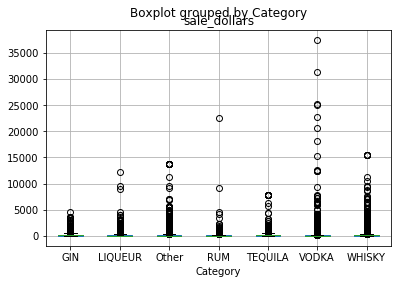

In [0]:
# pandas has some really powerful extensions to matplotlib for scientific computing 
ax = df.boxplot(column = 'sale_dollars', by = 'Category')
ax



This box plot is graphing the distribution sale_dollars with the different categories of liquor we have available. Here, we can see there is a significant number of outliers across all categories, so much that you can't really see the boxes on each category. This would suggest we would want to look into a transform.

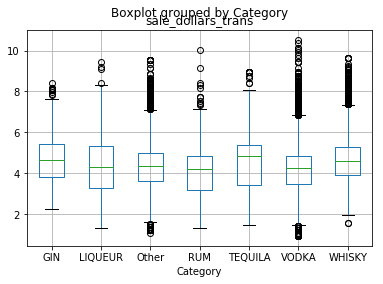

In [0]:
df['sale_dollars_trans'] = np.log(df['sale_dollars'])

gx = df.boxplot(column = 'sale_dollars_trans', by = 'Category')
gx


This is much more helpful for us to see how our distribution of categories compares to one another. Vodka and Whiskey are still showing a wider range of outliers, however Liquer tends to have a wider bounding than the other categories, which suggests that it has a wide variety of pricing. On average, tequila looks to have the higher medium sale value, which suggest that more money is being spent on tequilla on average. 

Using Sales dollars trans will help address outliers in the future.

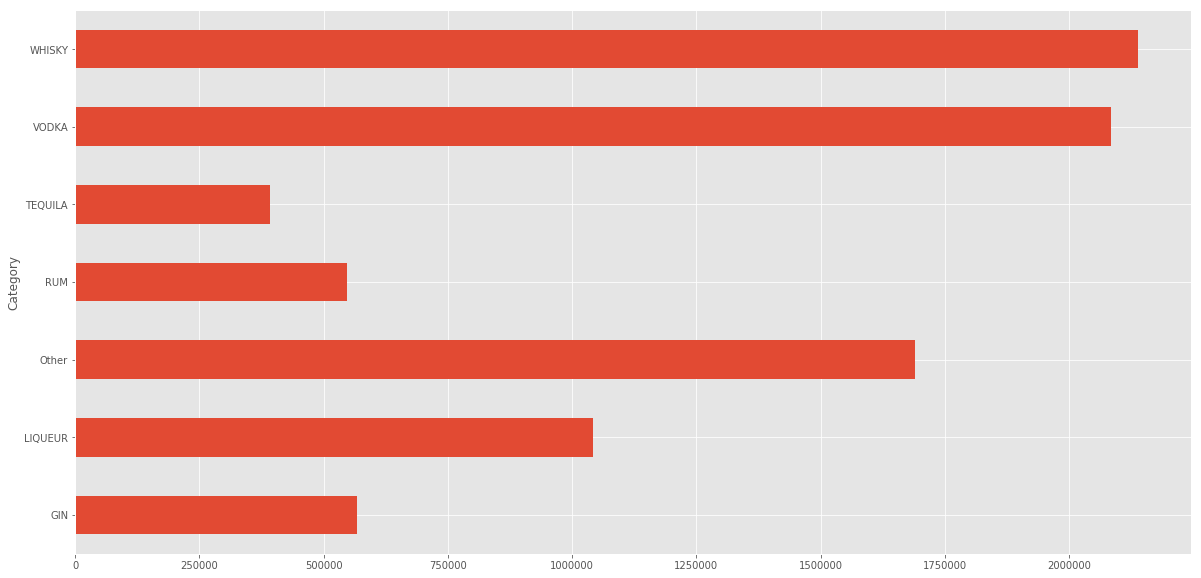

In [0]:
# Start by just plotting what we previsously grouped!
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
df_grouped = df.groupby(by=['Category'])
sales_rate = df_grouped.sale_dollars.sum()
ax = sales_rate.plot(kind='barh')

Looking at an agregate of our different alcohol categories, we can see that Whiskey generated the highest number of sales in our datase at close to 2.5 million followed by vodka at closer to 2 million. This chart seems to show that Vodka and Whiskey are the two most highest selling alcohols in the state of Iowa in 2019 with no one liquor coming close. 

In [0]:
df_grouped.head(5)

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,Category,store_parent,month,year,monthyear,sale_dollars_trans
0,INV-23084400002,2019-11-07,3869,Bootleggin' Barzini's Fin,412 1st Ave,Coralville,52241,POINT (-91.565517 41.672672),52,JOHNSON,...,20.0,115.60,7.50,1.98,Other,Other,Nov,2019,Nov-2019,4.750136
1,INV-23282200001,2019-11-18,4617,Lickety Liquor,2501 HUBBELL AVE,Des Moines,50317,POINT (-93.570489 41.607817),77,POLK,...,1.0,13.13,0.05,0.01,Other,Other,Nov,2019,Nov-2019,2.574900
2,INV-19435800130,2019-05-17,2560,Hy-Vee Food Store / Marion,3600 Business Hwy 151 East,Marion,52302,blank,57,LINN,...,6.0,148.50,6.00,1.58,GIN,Hy-Vee,May,2019,May-2019,5.000585
3,INV-23454200002,2019-11-25,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,...,24.0,762.24,18.00,4.75,WHISKY,Hy-Vee,Nov,2019,Nov-2019,6.636261
4,INV-23541200001,2019-11-27,2629,Hy-Vee Food Store #2 / Council Bluffs,1745 Madison Ave,Council Bluffs,51503,POINT (-95.825137 41.242732),78,POTTAWATTA,...,12.0,167.64,21.00,5.54,Other,Hy-Vee,Nov,2019,Nov-2019,5.121819
5,INV-23540300028,2019-11-27,4312,I-80 Liquor / Council Bluffs,2411 S 24TH ST #1,Council Bluffs,51501,POINT (-95.8792 41.238092),78,POTTAWATTA,...,6.0,260.82,6.00,1.58,WHISKY,Other,Nov,2019,Nov-2019,5.563831
6,INV-19655400089,2019-05-29,2517,Hy-Vee Food Store #1 / Newton,1501 First Avenue East,Newton,50208,POINT (-93.034296 41.69916),50,JASPER,...,12.0,88.20,6.00,1.58,Other,Hy-Vee,May,2019,May-2019,4.479607
7,INV-23687700099,2019-12-05,2545,Hy-Vee Drugstore / Iowa City,310 N 1st St,Iowa City,52245,POINT (-91.528105 42.207428),52,JOHNSON,...,30.0,382.50,22.50,5.94,Other,Hy-Vee,Dec,2019,Dec-2019,5.946729
14,INV-23566000005,2019-11-29,4192,Fareway Stores #044 / Bettendorf,3800 Belmont Rd,Bettendorf,52722,POINT (-90.480368 41.556273),82,SCOTT,...,24.0,449.76,18.00,4.75,LIQUEUR,Fareway,Nov,2019,Nov-2019,6.108714
15,INV-19970300001,2019-06-13,2675,Hy-Vee #2 / Coralville,3285 Crosspark Rd,Coralville,52241,POINT (-91.60627100000002 41.721438),52,JOHNSON,...,18.0,583.02,13.50,3.56,WHISKY,Hy-Vee,Jun,2019,Jun-2019,6.368221


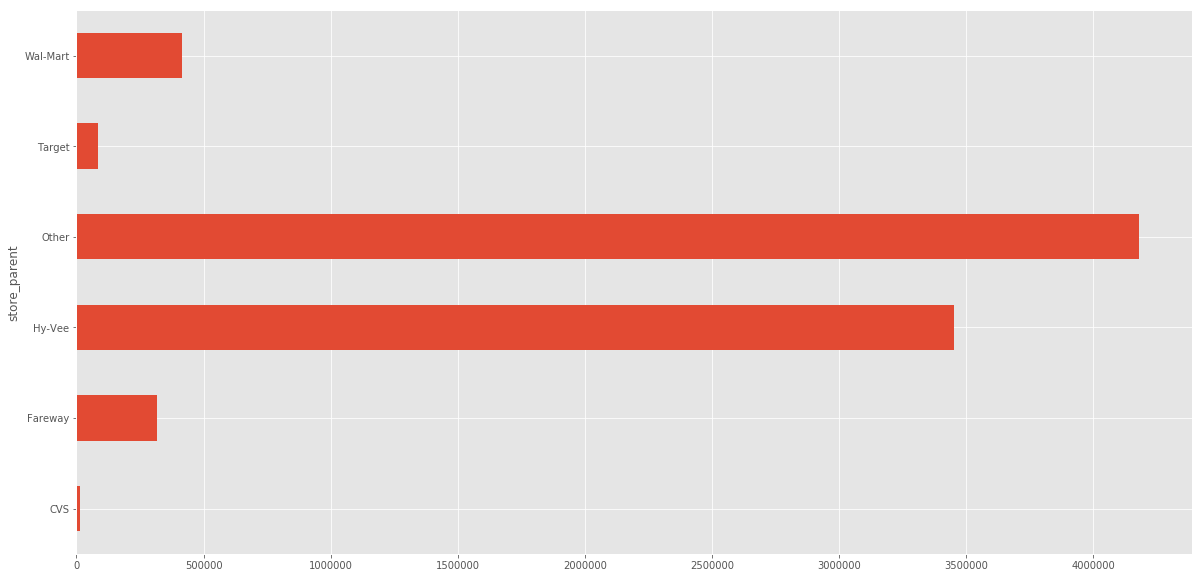

In [0]:
# Start by just plotting what we previsously grouped!
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
df_grouped = df.groupby(by=['store_parent'])
sales_rate = df_grouped.sale_dollars.sum()
ax = sales_rate.plot(kind='barh')

For our stores in our dataset, as we discussed previously, we decided to focus on the big box retailers as our starting point, and lumped in the smaller stores into a category called "other". As we can see, the other column drove the greatest overall sales at over 4 million, however the Hy Vee in iowa was close to it at nearly 3.5 million in sales. In the state of Iowa, Hy Vee is a widely popular grocery store chain in Iowa that sales alocholic beverages as per the laws in Iowa. 

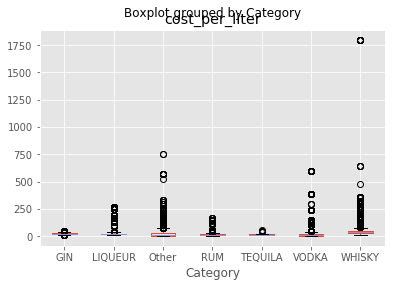

In [0]:
df['cost_per_liter'] = df['sale_dollars']/df['volume_sold_liters']


bx = df.boxplot(column = 'cost_per_liter', by = 'Category')
bx

Looking at the cost per liter aggregate column. As we discussed previously, cost per liter is calculated via a calculation of total sales_dollars divided by the total volume_sold_ml. The idea of this calculation is to see the varying price of the liquors if we normalize by the volume and sale of the liquors in our set. 

Here, we can see that our distribution is right skewed with a large outlier for whiskey which is going for over 1750 per liter. Looking further into this datapoint, we can see that this datapoint represents Johnnie Walker Blue. 

That said, with the distribution of alcohol types, outside of Johnnie walker blue, we cans see that our cost per liter is going to have a greater than tenfold range, so, i would suggest we create a transform there as well. 

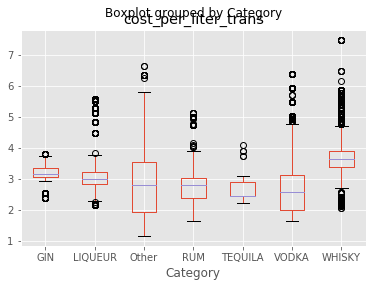

In [0]:
df['cost_per_liter_trans'] = np.log(df['cost_per_liter'])

zx = df.boxplot(column = 'cost_per_liter_trans', by = 'Category')
zx

This new box plot shows some interesting insight into the distribution and the value placed on alcohol in our dataset. 

Gin and Tequilla - even with outliers, it is going to have a faily consistent price per liter. 
Liquer - Similar case as GIn, however, it's outliers go a little farther out. 
Other- as expected, has a very wide range with very few outliers. Since this represents all types of alcohol not covered in the other categories, the box plot shape is expected. 

Whiskey - Has a faily consistent bounding, however the number out outliers on either side is very large and larger than the other categories. 

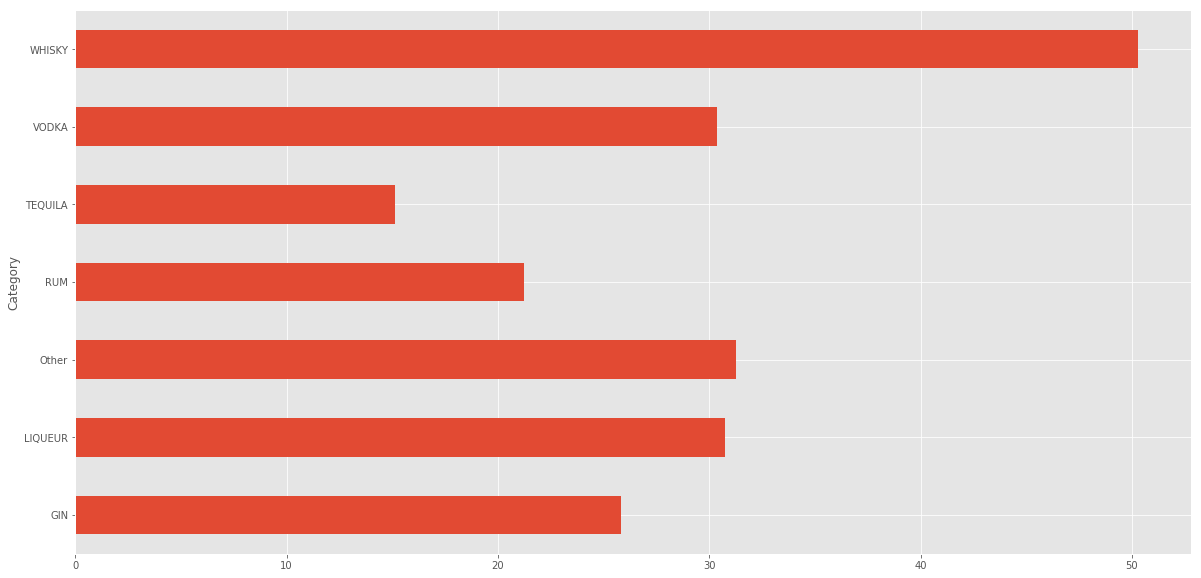

In [0]:
# Start by just plotting what we previsously grouped!
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
df_grouped = df.groupby(by=['Category'])
sales_rate = df_grouped.cost_per_liter.mean()
ax = sales_rate.plot(kind='barh')

This plot shows the grouped average cost per liter by the type of liquor in our dataset. Coming in at over 50 dollars per liter, whiskey is the most expensive alcohol in our dataset. However, some of that can come from the Johnnie Walker Blue we discussed previously, the common theme is that whiskey tends to be more expensive liter for liter than the other types of alcohol.

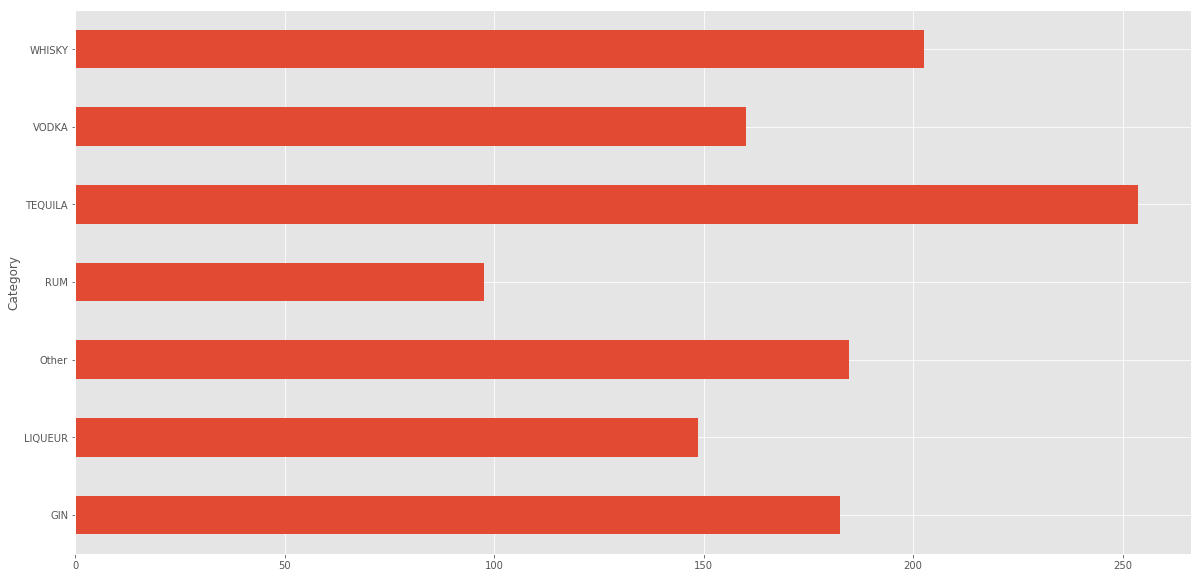

In [0]:
# Start by just plotting what we previsously grouped!
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
df_grouped = df.groupby(by=['Category'])
sales_rate = df_grouped.sale_dollars.mean()
ax = sales_rate.plot(kind='barh')

While whiskey had the highest average cost per liter, the vodka tended to have the highest sale value per purchase among all the alcohol types. This can be attributed to the volume in which vodka can be made and shipped, which likely affected the volume of sale. 

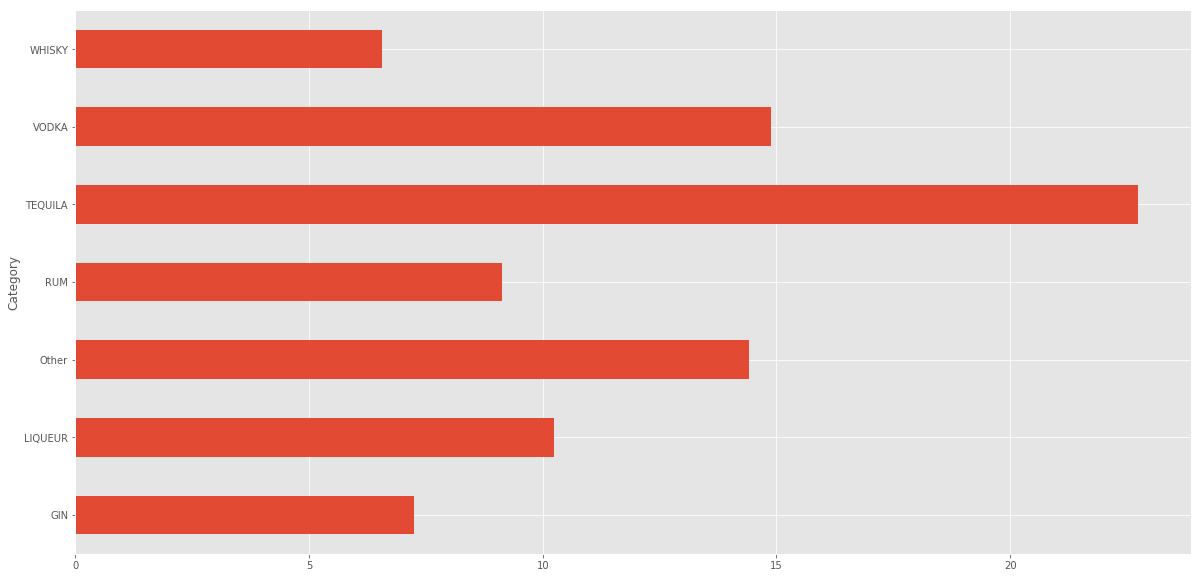

In [0]:
# Start by just plotting what we previsously grouped!
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
df_grouped = df.groupby(by=['Category'])
sales_rate = df_grouped.bottles_sold.mean()
ax = sales_rate.plot(kind='barh')

Looking at the average bottles sold per pack by way of the liquor categories in our dataset, tequila had the highest amount with over 20 bottles sold per purchase on average. This can be followed by vodka which was referenced earlier.

## Add whiskey specific analysis

Refining market to whiskey to gather further information about whiskey vendors. Since our analysis is going to focus strictly on whiskey sales, it will be important to see how the whiskey distribution looks within our dataset.  

The first thing we are going to reload our dataset as dfwhiskey and replace our nan values as blanks and convert our category_name strings as upper case variables. Like before we are going to categorize our liquors, add dates as well as store names so that we are working with a similar dataset as before. 

In [0]:
#analyze only whiskey
#seperate dataframe limited to whiskey
dfwhiskey = pd.read_csv(r'/Users/jjschued/Documents/Github/7331DataMiningNotebooks/lab1/iowa_subset_2019_400k_random_rows.csv')
#dfwhiskey = pd.read_csv(r'/Users/danielclark/Desktop/SMU/data_mining/7331DataMiningNotebooks/lab1/iowa_subset_2019_400k_random_rows.csv')


#convert nan to blanks
dfwhiskey = (dfwhiskey.replace(r'^\s*$', np.nan, regex=True))
dfwhiskey = (dfwhiskey.replace(np.nan, 'blank', regex=True))

#upper case category name for matching later
dfwhiskey['category_name'] = dfwhiskey['category_name'].str.upper()

#grouping all the store locations into parent stores
dfwhiskey['Category'] = 'Other'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('GINS'), 'Category'] = 'GIN'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('GINS'), 'Category'] = 'GIN'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('GIN'), 'Category'] = 'GIN'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('RUMS'), 'Category'] = 'RUM'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('RUM'), 'Category'] = 'RUM'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('SCOTCH'), 'Category'] = 'WHISKY'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('WHISKIES'), 'Category'] = 'WHISKY'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('WHISKY'), 'Category'] = 'WHISKY'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('WHISKEY'), 'Category'] = 'WHISKY'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('RYE'), 'Category'] = 'WHISKY'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('AMARETTO'), 'Category'] = 'AMARETTO'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('BOURBON'), 'Category'] = 'WHISKY'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('LIQUEURS'), 'Category'] = 'LIQUEUR'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('LIQUEUR'), 'Category'] = 'LIQUEUR'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('VODKAS'), 'Category'] = 'VODKA'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('VODKA'), 'Category'] = 'VODKA'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('BRANDY'), 'Category'] = 'BRANDY'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('BRANDIES'), 'Category'] = 'GIN'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('CREME'), 'Category'] = 'SCHNAPPS'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('SCHNAPPS'), 'Category'] = 'SCHNAPPS'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('TEQUILA'), 'Category'] = 'TEQUILA'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('TEQUILAS'), 'Category'] = 'TEQUILA'

#get a few stray not available categories per internet this is tequila
dfwhiskey.loc[dfwhiskey['item_description'] == 'Herradura Gold Reposado 6pak', 'Category'] = "Tequila"
dfwhiskey.loc[dfwhiskey['item_description'] == 'Chambord Liqueur w/2 Glasses', 'Category'] = "Liquers"

#grouping all the store locations into parent stores
dfwhiskey['store_parent'] = 'Other'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('Hy-Vee'), 'store_parent'] = 'Hy-Vee'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('Wal-Mart'), 'store_parent'] = 'Wal-Mart'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('SamsClub'), 'store_parent'] = 'SamsClub'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('Fareway'), 'store_parent'] = 'Fareway'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('Kum&Go'), 'store_parent'] = 'Kum&Go'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('CVS'), 'store_parent'] = 'CVS'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('Target'), 'store_parent'] = 'Target'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('Caseys'), 'store_parent'] = 'Caseys'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('Dahls'), 'store_parent'] = 'Dahls'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('WAL-MART'), 'store_parent'] = 'Wal-Mart'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('HY-VEE'), 'store_parent'] = 'Hy-Vee'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('KUM&GO'), 'store_parent'] = 'Kum&Go'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('QuikTrip'), 'store_parent'] = 'QuikTrip'


#labored conversion of dates to month year and month year by converting to strings
dfwhiskey['month'] = pd.DatetimeIndex(dfwhiskey['date']).month
dfwhiskey['year'] = pd.DatetimeIndex(dfwhiskey['date']).year

dfwhiskey.loc[dfwhiskey['month'] ==1 , 'month'] = 'Jan'
dfwhiskey.loc[dfwhiskey['month'] ==2 , 'month'] = 'Feb'
dfwhiskey.loc[dfwhiskey['month'] ==3 , 'month'] = 'Mar'
dfwhiskey.loc[dfwhiskey['month'] ==4 , 'month'] = 'Apr'
dfwhiskey.loc[dfwhiskey['month'] ==5 , 'month'] = 'May'
dfwhiskey.loc[dfwhiskey['month'] ==6 , 'month'] = 'Jun'
dfwhiskey.loc[dfwhiskey['month'] ==7 , 'month'] = 'Jul'
dfwhiskey.loc[dfwhiskey['month'] ==8 , 'month'] = 'Aug'
dfwhiskey.loc[dfwhiskey['month'] ==9 , 'month'] = 'Sep'
dfwhiskey.loc[dfwhiskey['month'] ==10 , 'month'] = 'Oct'
dfwhiskey.loc[dfwhiskey['month'] ==11 , 'month'] = 'Nov'
dfwhiskey.loc[dfwhiskey['month'] ==12 , 'month'] = 'Dec'


dfwhiskey.loc[dfwhiskey['year'] ==2012 , 'year'] = '2012'
dfwhiskey.loc[dfwhiskey['year'] ==2013 , 'year'] = '2013'
dfwhiskey.loc[dfwhiskey['year'] ==2014 , 'year'] = '2014'
dfwhiskey.loc[dfwhiskey['year'] ==2015 , 'year'] = '2015'
dfwhiskey.loc[dfwhiskey['year'] ==2016 , 'year'] = '2016'
dfwhiskey.loc[dfwhiskey['year'] ==2017 , 'year'] = '2017'
dfwhiskey.loc[dfwhiskey['year'] ==2018 , 'year'] = '2018'
dfwhiskey.loc[dfwhiskey['year'] ==2019 , 'year'] = '2019'

#merge year and month together
dfwhiskey['monthyear'] = dfwhiskey['month'] + "-" + dfwhiskey['year']


Here's the head of our dataset so we can see how it looks.

In [0]:
dfwhiskey.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,Category,store_parent,month,year,monthyear
0,INV-23084400002,2019-11-07,3869,Bootleggin' Barzini's Fin,412 1st Ave,Coralville,52241,POINT (-91.565517 41.672672),52,JOHNSON,...,5.78,20,115.60,7.50,1.98,Other,Other,Nov,2019,Nov-2019
1,INV-23282200001,2019-11-18,4617,Lickety Liquor,2501 HUBBELL AVE,Des Moines,50317,POINT (-93.570489 41.607817),77,POLK,...,13.13,1,13.13,0.05,0.01,Other,Other,Nov,2019,Nov-2019
2,INV-19435800130,2019-05-17,2560,Hy-Vee Food Store / Marion,3600 Business Hwy 151 East,Marion,52302,blank,57,LINN,...,24.75,6,148.50,6.00,1.58,GIN,Hy-Vee,May,2019,May-2019
3,INV-23454200002,2019-11-25,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,...,31.76,24,762.24,18.00,4.75,WHISKY,Hy-Vee,Nov,2019,Nov-2019
4,INV-23541200001,2019-11-27,2629,Hy-Vee Food Store #2 / Council Bluffs,1745 Madison Ave,Council Bluffs,51503,POINT (-95.825137 41.242732),78,POTTAWATTA,...,13.97,12,167.64,21.00,5.54,Other,Hy-Vee,Nov,2019,Nov-2019


Next, we are going to redefine our dataset to focus entirely on the whiskey category and rename our original dataset as dfwhiskey. 

In [0]:
dfwhiskey = dfwhiskey[dfwhiskey['Category']=='WHISKY']

Here is another top view of our dataset to show how it looks from above. 

In [0]:
dfwhiskey.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,Category,store_parent,month,year,monthyear
3,INV-23454200002,2019-11-25,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,...,31.76,24,762.24,18.0,4.75,WHISKY,Hy-Vee,Nov,2019,Nov-2019
5,INV-23540300028,2019-11-27,4312,I-80 Liquor / Council Bluffs,2411 S 24TH ST #1,Council Bluffs,51501,POINT (-95.8792 41.238092),78,POTTAWATTA,...,43.47,6,260.82,6.0,1.58,WHISKY,Other,Nov,2019,Nov-2019
15,INV-19970300001,2019-06-13,2675,Hy-Vee #2 / Coralville,3285 Crosspark Rd,Coralville,52241,POINT (-91.60627100000002 41.721438),52,JOHNSON,...,32.39,18,583.02,13.5,3.56,WHISKY,Hy-Vee,Jun,2019,Jun-2019
24,INV-23645000007,2019-12-03,5866,Hometown Family Market,310 2nd St,Gladbrook,50635,POINT (-92.716422 42.187653),86,TAMA,...,31.50,2,63.00,2.0,0.52,WHISKY,Other,Dec,2019,Dec-2019
29,INV-19201600066,2019-05-07,2651,Hy-Vee / Waverly,1311 4 Street SW,Waverly,50677,POINT (-92.475403 42.712263),9,BREMER,...,27.14,30,814.20,22.5,5.94,WHISKY,Hy-Vee,May,2019,May-2019


Next, we are going to do a series of calculations to add new columns to our dataset which provides some insight to the sales data of our whiskies. 

These include the following new features:
- cost per liter = sale_dollars / volume_sale_ml
- profit = state_bottle_retail / bottles_sold
- totalcost = state_bottle_cost * bottles_sold
- revenue = state_bottle_retail * bottles_sold
- grossmargin = (revenue - totalcost)/revenue

Ultimately, this is going to give us a clear view of the profatability, and the market size of whiskey so we can better analyze and predict within the dataset.

In [0]:
#do some calculations for cost and profit
dfwhiskey['cost_per_liter'] = dfwhiskey['sale_dollars']/dfwhiskey['volume_sold_liters']

In [0]:
dfwhiskey['profit'] = dfwhiskey['state_bottle_retail']*dfwhiskey['bottles_sold'] - dfwhiskey['state_bottle_cost']* dfwhiskey['bottles_sold']

In [0]:
dfwhiskey['totalcost'] = dfwhiskey['state_bottle_cost']* dfwhiskey['bottles_sold']

In [0]:
dfwhiskey['revenue'] = dfwhiskey['state_bottle_retail']*dfwhiskey['bottles_sold']

In [0]:
dfwhiskey['grossmargin'] = (dfwhiskey['revenue'] - dfwhiskey['totalcost']) / dfwhiskey['revenue']

Here, we sorted gross margin of sale within our data set to get a clearer view of how margins tend to look within the sales in our dataset. 

As we can see, there is a 33% margin that appears across almost all of our sales when you calculate the percentage of what is remaining from the cost over the revenue. We are thiking that is a standard state tax cost for whiskies in the state of Iowa.

In [0]:
#lets do the transforms we did earlier in the EDA
dfwhiskey['sale_dollars_trans'] = np.log(dfwhiskey['sale_dollars'])
dfwhiskey['cost_per_liter_trans'] = np.log(dfwhiskey['cost_per_liter'])

In [0]:
dfwhiskey.sort_values(by='grossmargin', ascending=False).head(100)

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,month,year,monthyear,cost_per_liter,profit,totalcost,revenue,grossmargin,sale_dollars_trans,cost_per_liter_trans
121625,INV-18344800004,2019-03-26,5443,1st Stop Beverage Shop,2839 East University Ave.,Des Moines,50317,POINT (-93.561517 41.600476),77,POLK,...,Mar,2019,Mar-2019,12.853333,38.64,77.04,115.68,0.334025,4.750828,2.553603
121334,INV-19122500001,2019-05-02,2501,Hy-Vee #2 / Ames,640 Lincolnway,Ames,50010,POINT (-93.619455 42.022848),85,STORY,...,May,2019,May-2019,12.853333,9.66,19.26,28.92,0.334025,3.364533,2.553603
121653,INV-19341100016,2019-05-14,5286,Sauce,"108, College",Iowa City,52240,blank,52,JOHNSON,...,May,2019,May-2019,12.853333,38.64,77.04,115.68,0.334025,4.750828,2.553603
121329,INV-17879500032,2019-03-04,2560,Hy-Vee Food Store / Marion,3600 Business Hwy 151 East,Marion,52302,blank,57,LINN,...,Mar,2019,Mar-2019,12.853333,9.66,19.26,28.92,0.334025,3.364533,2.553603
36719,INV-19151100019,2019-05-03,4106,Hartig Drug Company #3/JFK,2255 John F Kennedy Rd,Dubuque,52002,POINT (-90.72051800000001 42.511352),31,DUBUQUE,...,May,2019,May-2019,12.910714,4.83,9.63,14.46,0.334025,2.671386,2.558058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38576,INV-16714800233,2019-01-03,2603,Hy-Vee Wine and Spirits / Bettendorf,2890 Devils Glen Road,Bettendorf,52722,POINT (-90.483701 41.552338),82,SCOTT,...,Jan,2019,Jan-2019,10.266667,5.14,10.26,15.40,0.333766,2.734368,2.328902
121804,INV-21117100019,2019-08-08,4135,Fareway Stores #925 / Altoona,620 SE 8th St,Altoona,50009,POINT (-93.458606 41.644082000000004),77,POLK,...,Aug,2019,Aug-2019,10.266667,5.14,10.26,15.40,0.333766,2.734368,2.328902
78917,INV-20962200017,2019-07-31,4247,Fareway Stores #879 / Belmond,512 River Ave N,Belmond,50421,POINT (-93.616788 42.850357),99,WRIGHT,...,Jul,2019,Jul-2019,9.600000,10.28,20.52,30.80,0.333766,3.360375,2.261763
78831,INV-17201100004,2019-01-28,2591,Hy-Vee Wine and Spirits / Atlantic,1602 E 7th St,Atlantic,50022,POINT (-94.990031 41.403856),15,CASS,...,Jan,2019,Jan-2019,10.266667,10.28,20.52,30.80,0.333766,3.427515,2.328902


Looking at more grossmargin values, we still see the same 33%

In [0]:
dfwhiskey.head(10)

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,month,year,monthyear,cost_per_liter,profit,totalcost,revenue,grossmargin,sale_dollars_trans,cost_per_liter_trans
3,INV-23454200002,2019-11-25,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,...,Nov,2019,Nov-2019,42.346667,254.16,508.08,762.24,0.333438,6.636261,3.745890
5,INV-23540300028,2019-11-27,4312,I-80 Liquor / Council Bluffs,2411 S 24TH ST #1,Council Bluffs,51501,POINT (-95.8792 41.238092),78,POTTAWATTA,...,Nov,2019,Nov-2019,43.470000,86.94,173.88,260.82,0.333333,5.563831,3.772071
15,INV-19970300001,2019-06-13,2675,Hy-Vee #2 / Coralville,3285 Crosspark Rd,Coralville,52241,POINT (-91.60627100000002 41.721438),52,JOHNSON,...,Jun,2019,Jun-2019,43.186667,194.40,388.62,583.02,0.333436,6.368221,3.765532
24,INV-23645000007,2019-12-03,5866,Hometown Family Market,310 2nd St,Gladbrook,50635,POINT (-92.716422 42.187653),86,TAMA,...,Dec,2019,Dec-2019,31.500000,21.00,42.00,63.00,0.333333,4.143135,3.449988
29,INV-19201600066,2019-05-07,2651,Hy-Vee / Waverly,1311 4 Street SW,Waverly,50677,POINT (-92.475403 42.712263),9,BREMER,...,May,2019,May-2019,36.186667,271.50,542.70,814.20,0.333456,6.702206,3.588691
30,INV-23443700008,2019-11-25,2536,HY-VEE / PLEASANT HILL,4815 Maple Drive,Pleasant Hill,50317,POINT (-93.519187 41.598109),77,Polk,...,Nov,2019,Nov-2019,48.960000,734.40,1468.80,2203.20,0.333333,7.697666,3.891004
32,INV-20172700090,2019-06-24,2512,Hy-Vee Wine and Spirits / Iowa City,1720 Waterfront Dr,Iowa City,52240,POINT (-91.53046300000001 41.642764),52,JOHNSON,...,Jun,2019,Jun-2019,23.080000,138.48,276.96,415.44,0.333333,6.029338,3.138966
79,INV-23172800009,2019-11-12,3881,7 Rayos Liquor Store,120 E Main St,Marshalltown,50158,POINT (-92.9104 42.049166),64,MARSHALL,...,Nov,2019,Nov-2019,31.500000,42.00,84.00,126.00,0.333333,4.836282,3.449988
81,INV-19221100078,2019-05-07,5351,Downtown Liquor,1203 5th St.,Sioux City,51101,POINT (-96.394671 42.495324),97,WOODBURY,...,May,2019,May-2019,43.470000,28.98,57.96,86.94,0.333333,4.465218,3.772071
85,INV-23526800002,2019-11-27,2521,Hy-Vee Food and Drug / Grand / WDM,1990 Grand Avenue,West Des Moines,50265,POINT (-93.73162 41.571127),77,POLK,...,Nov,2019,Nov-2019,80.000000,360.00,720.00,1080.00,0.333333,6.984716,4.382027


In [0]:
df_grouped = dfwhiskey.groupby(by=['vendor_name'])
df_grouped.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,month,year,monthyear,cost_per_liter,profit,totalcost,revenue,grossmargin,sale_dollars_trans,cost_per_liter_trans
3,INV-23454200002,2019-11-25,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,...,Nov,2019,Nov-2019,42.346667,254.16,508.08,762.24,0.333438,6.636261,3.745890
5,INV-23540300028,2019-11-27,4312,I-80 Liquor / Council Bluffs,2411 S 24TH ST #1,Council Bluffs,51501,POINT (-95.8792 41.238092),78,POTTAWATTA,...,Nov,2019,Nov-2019,43.470000,86.94,173.88,260.82,0.333333,5.563831,3.772071
15,INV-19970300001,2019-06-13,2675,Hy-Vee #2 / Coralville,3285 Crosspark Rd,Coralville,52241,POINT (-91.60627100000002 41.721438),52,JOHNSON,...,Jun,2019,Jun-2019,43.186667,194.40,388.62,583.02,0.333436,6.368221,3.765532
24,INV-23645000007,2019-12-03,5866,Hometown Family Market,310 2nd St,Gladbrook,50635,POINT (-92.716422 42.187653),86,TAMA,...,Dec,2019,Dec-2019,31.500000,21.00,42.00,63.00,0.333333,4.143135,3.449988
29,INV-19201600066,2019-05-07,2651,Hy-Vee / Waverly,1311 4 Street SW,Waverly,50677,POINT (-92.475403 42.712263),9,BREMER,...,May,2019,May-2019,36.186667,271.50,542.70,814.20,0.333456,6.702206,3.588691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246015,INV-21252600005,2019-08-15,4129,Cyclone Liquors,626 Lincoln Way,Ames,50010,POINT (-93.618911 42.022854),85,STORY,...,Aug,2019,Aug-2019,60.000000,90.00,180.00,270.00,0.333333,5.598422,4.094345
314264,INV-21229200003,2019-08-14,3773,Benz Distributing,501 7th Ave SE,Cedar Rapids,52401,POINT (-91.659875 41.97574),57,LINN,...,Aug,2019,Aug-2019,19.986667,90.00,179.82,269.82,0.333556,5.597755,2.995065
314265,INV-17524000177,2019-02-13,4129,Cyclone Liquors,626 Lincoln Way,Ames,50010,POINT (-93.618911 42.022854),85,STORY,...,Feb,2019,Feb-2019,19.986667,5.00,9.99,14.99,0.333556,2.707383,2.995065
314266,INV-19589600071,2019-05-24,3868,Wal-Mart 3630 / Marion,5491 Business Hwy 151,Marion,52302,blank,57,LINN,...,May,2019,May-2019,19.986667,30.00,59.94,89.94,0.333556,4.499143,2.995065


To look into some aggregate sums within our whiskey dataset, we are going to create new varuables for the sum of bottles sold and sale_dollars, as well as the mean of cost per liter and gross margin. 

Also, we will create datagrames for each so we can see how the whiskey's distribute in these aggregate figures.

In [0]:
sales_rateq = df_grouped.bottles_sold.sum()
sales_rated = df_grouped.sale_dollars.sum()
sales_ratecpl = df_grouped.cost_per_liter.mean()
salesgm = df_grouped.grossmargin.mean()

In [0]:
dfsr = pd.DataFrame(sales_rateq)
dfsdol = pd.DataFrame(sales_rated)
dfscpl = pd.DataFrame(sales_ratecpl)
dfsg = pd.DataFrame(salesgm)

In [0]:
dfsr.sort_values(by='bottles_sold', ascending=False).head(10)

,bottles_sold
vendor_name,
PERNOD RICARD USA,105068
DIAGEO AMERICAS,29552
Infinium Spirits,22497
William Grant & Sons Inc,15926
SAZERAC NORTH AMERICA,10698
SAZERAC COMPANY INC,10665
Jim Beam Brands,8651
BACARDI USA INC,7716
CEDAR RIDGE VINEYARDS LL,4411


Looking at the top 10 bottles sold in the whiskey category, we can see that the number one on the list is Pernod Ricard at over 100k bolttles sold, followed distantly by Dieago Americas at 29,500. 

In [0]:
dfsdol.sort_values(by='sale_dollars', ascending=False).head(10)

,sale_dollars
vendor_name,
PERNOD RICARD USA,2965631.76
DIAGEO AMERICAS,935867.44
Infinium Spirits,634224.71
William Grant & Sons Inc,509568.03
Jim Beam Brands,227406.10
BACARDI USA INC,216439.87
SAZERAC COMPANY INC,188508.57
Edrington Group USA LLC,185043.45
MOET HENNESSY USA,168206.25


As a function of bottles sold, we are seeing a similar distirbution with regards to sale_dollars in our top whiskies. Pernod Richard is nearing 3 million dollars in sales followed by Diageo Americas that is under 1 million dollars in sales. 

In [0]:
dfscpl.sort_values(by='cost_per_liter', ascending=False).head(10)

,cost_per_liter
vendor_name,
PACIFIC EDGE WINE & SPIRITS,145.564444
IMPEX BEVERAGE INC,123.086667
HOTALING & CO,104.243810
W J Deutsch & Sons LTD,93.320000
GoAmericaGo Beverages LLC,89.461075
MOET HENNESSY USA,74.180870
"Foundry Distilling Company, LLC",71.983333
Vision Wine & Spirit LLC,69.010256
Paterno Imports LTD,68.098667


Interestingly, looking at the high cost per liter vendors, Pactific Edge Wine and Spirits has the highest cost per liter at over 115 dollars, followed by Impex Beverage and Hotaling at just over 100 dollars. 

In [0]:
salesbyvendor = pd.merge(dfsr, dfsdol, how = 'left', on='vendor_name')
salesbyvendor = pd.merge(salesbyvendor, dfscpl, how = 'left', on='vendor_name')
salesbyvendor = pd.merge(salesbyvendor, dfsg, how = 'left', on='vendor_name')
salesbyvendor

,bottles_sold,sale_dollars,cost_per_liter,grossmargin
vendor_name,,,,
"American Heritage Distillers, LLC",12,189.60,21.066667,0.333544
BACARDI USA INC,7716,216439.87,28.791171,0.333334
BAD BEAR ENTERPRISES LLC,413,18987.00,60.047619,0.333333
Brown Forman Corp.,2284,68098.15,41.052515,0.333437
CEDAR RIDGE VINEYARDS LL,4411,142926.26,44.172657,0.333396
...,...,...,...,...
Three Rangers,2,74.64,49.760000,0.333333
Vision Wine & Spirit LLC,54,2817.91,69.010256,0.333352
W J Deutsch & Sons LTD,19,1329.81,93.320000,0.333333


Next, we are going to merge our datasets so that we can group our measures of bottles sold, sale_dollars, cost_per_liter and gross margin by our 61 vendors, so we can see how they rank in our key finance values. 

In [0]:
salesbyvendor.sort_values(by='cost_per_liter', ascending=False).head(10)

,bottles_sold,sale_dollars,cost_per_liter,grossmargin
vendor_name,,,,
PACIFIC EDGE WINE & SPIRITS,36,3930.24,145.564444,0.333336
IMPEX BEVERAGE INC,36,3681.12,123.086667,0.333347
HOTALING & CO,48,3570.24,104.243810,0.333338
W J Deutsch & Sons LTD,19,1329.81,93.320000,0.333333
GoAmericaGo Beverages LLC,769,50006.25,89.461075,0.333375
MOET HENNESSY USA,3993,168206.25,74.180870,0.333417
"Foundry Distilling Company, LLC",499,15221.40,71.983333,0.333368
Vision Wine & Spirit LLC,54,2817.91,69.010256,0.333352
Paterno Imports LTD,30,1532.22,68.098667,0.333359


In [0]:
salesbyvendor.sort_values(by='sale_dollars', ascending=False).head(10)

,bottles_sold,sale_dollars,cost_per_liter,grossmargin
vendor_name,,,,
PERNOD RICARD USA,105068,2965631.76,50.308440,0.333377
DIAGEO AMERICAS,29552,935867.44,59.427849,0.333368
Infinium Spirits,22497,634224.71,38.625414,0.333439
William Grant & Sons Inc,15926,509568.03,51.849234,0.333346
Jim Beam Brands,8651,227406.10,36.642989,0.333391
BACARDI USA INC,7716,216439.87,28.791171,0.333334
SAZERAC COMPANY INC,10665,188508.57,17.979126,0.333383
Edrington Group USA LLC,4200,185043.45,66.699662,0.333400
MOET HENNESSY USA,3993,168206.25,74.180870,0.333417


In [0]:
salesbyvendor.sort_values(by='grossmargin', ascending=False).head(100)

,bottles_sold,sale_dollars,cost_per_liter,grossmargin
vendor_name,,,,
Castle Brands,232,3792.74,21.614884,0.333551
"American Heritage Distillers, LLC",12,189.60,21.066667,0.333544
Phillips Beverage,3317,58490.20,27.621371,0.333481
DUNKEL CORPORATION,360,9154.80,33.906667,0.333464
Cats Eye Distillery,199,5751.56,38.514497,0.333447
...,...,...,...,...
S&B Farmstead Distillery,120,4955.22,53.757500,0.333333
DEHNER DISTILLERY,87,2208.75,33.250000,0.333333
"Green Frog Distillery, LLC",760,18870.00,33.915663,0.333333


<Figure size 1440x720 with 0 Axes>

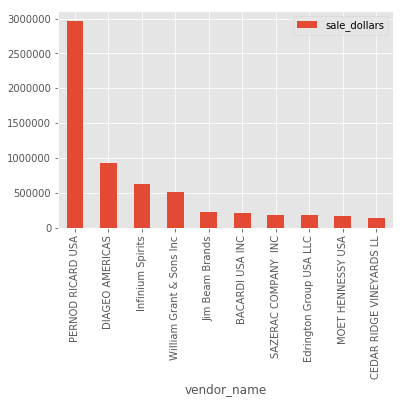

In [0]:
# Start by just plotting what we previsously grouped!
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
sales_rate = dfsdol.sort_values(by='sale_dollars', ascending=False).head(10)
ax = sales_rate.plot(kind='bar')

<Figure size 1440x720 with 0 Axes>

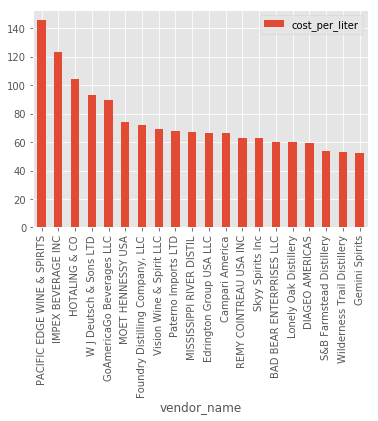

In [0]:
# Start by just plotting what we previsously grouped!
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
sales_rate = dfscpl.sort_values(by='cost_per_liter', ascending=False).head(20)
ax = sales_rate.plot(kind='bar')

Above are some additional plots to help you visualize a more complete dataset on cost per liter as well as sales dollar of our specific whiskeis in the study. As discussed before, the Pernod Richard whiskey is the top selling vendor,while Pacific Edge Whiskey has the highest cost per liter, ensinuating they are seeling the most valueable whiskey. 


![image.png](attachment:image.png)
If we are interested in big box retailers, lets look into Hy-Vee.

In [0]:
hv_df = pd.get_dummies(df['store_parent'], drop_first=False)

hv_df = pd.concat([df, hv_df], axis = 1, sort=False)

In [0]:
hv_df.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,monthyear,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,CVS,Fareway,Hy-Vee,Other,Target,Wal-Mart
0,INV-23084400002,2019-11-07,3869,Bootleggin' Barzini's Fin,412 1st Ave,Coralville,52241,POINT (-91.565517 41.672672),52,JOHNSON,...,Nov-2019,4.750136,15.413333,2.735233,0,0,0,1,0,0
1,INV-23282200001,2019-11-18,4617,Lickety Liquor,2501 HUBBELL AVE,Des Moines,50317,POINT (-93.570489 41.607817),77,POLK,...,Nov-2019,2.574900,262.600000,5.570632,0,0,0,1,0,0
2,INV-19435800130,2019-05-17,2560,Hy-Vee Food Store / Marion,3600 Business Hwy 151 East,Marion,52302,blank,57,LINN,...,May-2019,5.000585,24.750000,3.208825,0,0,1,0,0,0
3,INV-23454200002,2019-11-25,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,...,Nov-2019,6.636261,42.346667,3.745890,0,0,1,0,0,0
4,INV-23541200001,2019-11-27,2629,Hy-Vee Food Store #2 / Council Bluffs,1745 Madison Ave,Council Bluffs,51503,POINT (-95.825137 41.242732),78,POTTAWATTA,...,Nov-2019,5.121819,7.982857,2.077296,0,0,1,0,0,0


In [0]:
hv_grouped = hv_df.groupby(by=['Category', 'Hy-Vee']).median()
hv_grouped

pack  bottle_volume_ml  state_bottle_cost  \
Category Hy-Vee                                              
GIN      0         12              1000             15.500   
         1         12               750             16.500   
LIQUEUR  0         12               750             11.090   
         1         12               750             10.490   
Other    0          8               750             11.000   
         1         12               750              8.500   
RUM      0         12               750              7.350   
         1         12               750              8.390   
TEQUILA  0         12              1000              7.345   
         1         12              1000              7.830   
VODKA    0         12               750              7.110   
         1         12               750              7.920   
WHISKY   0         10               750             19.480   
         1          6               750             20.980   

                 state_bottle_retail  bottles_sold  sale_dollars  \
Category Hy-Vee                                                    
GIN      0                     23.25           4.0        93.000   
         1                     24.75           6.0       116.880   
LIQUEUR  0                     16.64           5.0        68.190   
         1                     15.74           6.0        89.740   
Other    0                     16.50           6.0        76.800   
         1                     12.75           6.0        78.750   
RUM      0                     11.03           6.0        66.180   
         1                     12.59           6.0        68.040   
TEQUILA  0                     11.02           6.0       125.280   
         1                     11.75          12.0       141.000   
VODKA    0                     10.67           6.0        69.600   
         1                     11.88           6.0        76.440   
WHISKY   0                     29.22           3.0        94.680   
         1                     31.47           3.0       107.235   

                 volume_sold_liters  volume_sold_gallons  sale_dollars_trans  \
Category Hy-Vee                                                                
GIN      0                     3.50                 0.92            4.532599   
         1                     4.50                 1.18            4.761148   
LIQUEUR  0                     3.00                 0.79            4.222298   
         1                     4.50                 1.18            4.496914   
Other    0                     4.50                 1.18            4.341205   
         1                     6.75                 1.78            4.366278   
RUM      0                     4.50                 1.18            4.192378   
         1                     3.75                 0.99            4.220096   
TEQUILA  0                     9.60                 2.53            4.830551   
         1                    12.00                 3.17            4.948760   
VODKA    0                     6.00                 1.58            4.242765   
         1                     9.00                 2.37            4.336506   
WHISKY   0                     2.25                 0.59            4.550503   
         1                     2.25                 0.59            4.675003   

                 cost_per_liter  cost_per_liter_trans  CVS  Fareway  Other  \
Category Hy-Vee                                                              
GIN      0            23.250000              3.146305    0        0      1   
         1            23.400000              3.152736    0        0      0   
LIQUEUR  0            19.950000              2.993229    0        0      1   
         1            19.950000              2.993229    0        0      0   
Other    0            20.800000              3.034953    0        0      1   
         1            14.700000              2.687847    0        0      0   
RUM      0            15.98666

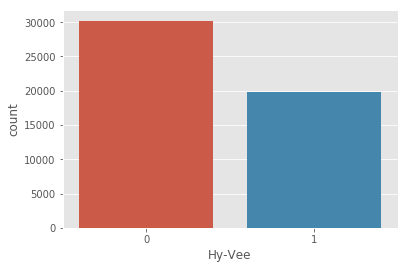

In [0]:
import seaborn as sns
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings
sns.countplot(x='Hy-Vee', data=hv_df);

Over 30k sales in our dataset were attributed to stores other than Hy-Vee, while the remaining 20k are from Hy-Vee

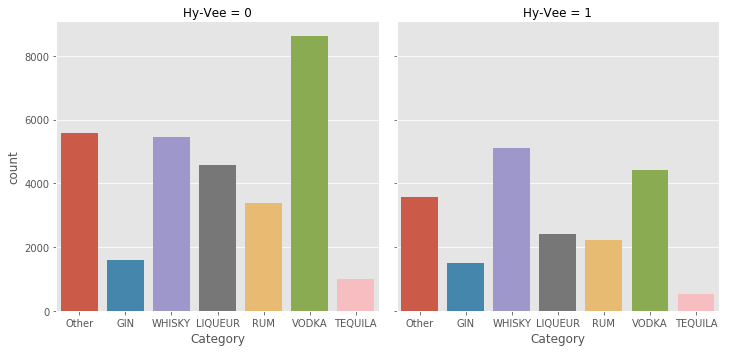

In [0]:
sns.catplot(x='Category', col='Hy-Vee', kind='count', data=hv_df);

In [0]:
pd.crosstab(hv_df.Category, hv_df['Hy-Vee'], margins=True).style.background_gradient(cmap='autumn_r')

Hy-Vee,0,1,All
Category,,,
GIN,1602,1499,3101
LIQUEUR,4583,2424,7007
Other,5585,3570,9155
RUM,3377,2231,5608
TEQUILA,1008,538,1546
VODKA,8618,4409,13027
WHISKY,5444,5112,10556
All,30217,19783,50000


In the two plots above, we can see the categorical sales tended to remain relatively consistent between Hy-Vee stores as opposed to other liquor stores in the area. This would suggest that Hy-Vee isn't buying liquor differently than anyone else in the state. 

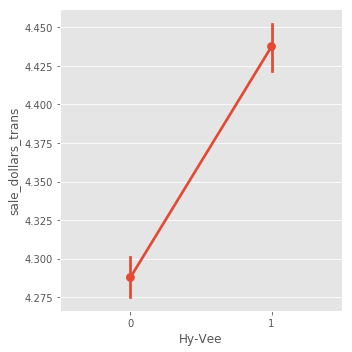

In [0]:
sns.catplot('Hy-Vee', "sale_dollars_trans", kind='point', data=hv_df)

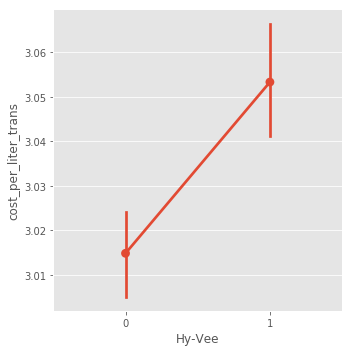

In [0]:
sns.catplot('Hy-Vee', "cost_per_liter_trans", kind='point', data=hv_df)

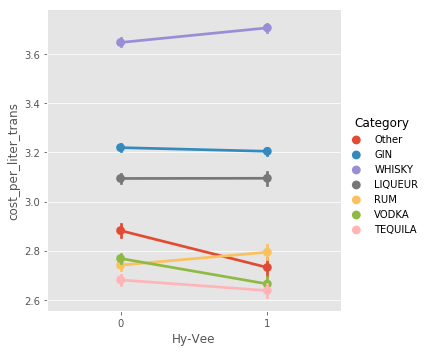

In [0]:
sns.catplot('Hy-Vee','cost_per_liter_trans',hue='Category', kind='point', data=hv_df);

I was curious to see if HyVee Charged Higher Prices than the competitors. Looking at the cost per liter (which would normalize liquor cost), It appears that Hy-Vee had much higher prices. However, grouping by category, we can see that this might have been dur to the volume of whiskey sales Hy-Vee had compared to non-hy-vee stores. The costs are pretty consistent. 

Lets try this with Small Liquor stores vs large big-box stores, using the same code as above but with Other instead of Hy-Vee.

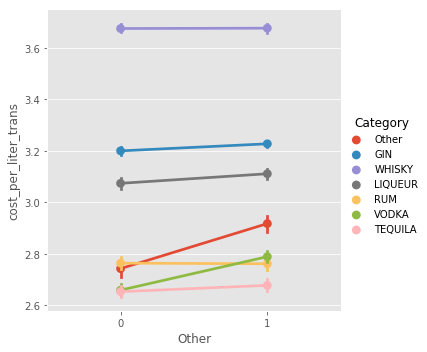

In [0]:
sns.catplot('Other','cost_per_liter_trans',hue='Category', kind='point', data=hv_df);

With 0 being Big Box Stores and 1 Being Small Retailers, we can see that consistently, Small Chains are charging higher prices. 

## Explore Joint Attributes
The next section dives deeper into the relationsihps between all the variables in our dataset as well as some of the key relationships found between our features. This will be a starting point for us to better understand if we can begin to think about addressing and removing highly correlated features in our set. 

To measure this, we will be able to run grid plots and heat maps with each feature against one another. The plots that are highly coorelated will be closer to 1 while the plots that are highly negatively correlated will be closer to -1. 

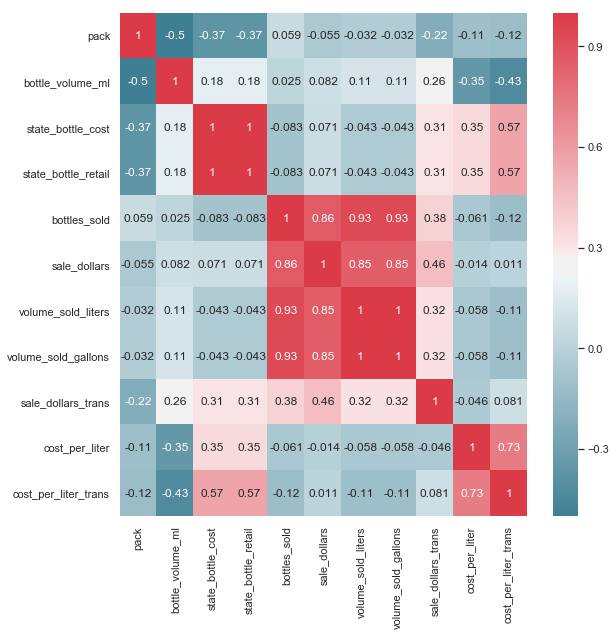

In [0]:
# plot the correlation matrix using seaborn
import seaborn as sns
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

sns.set(style="darkgrid") # one of the many styles to plot using
f, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(df.corr(), cmap=cmap, annot=True)
f.tight_layout()

Looking at a heat map of our coorelation plot, we can see some interesting occurances happening in the bottom right corner with regards to the volume stats as well as the sales stats. We are seeing cases of volume_sold_gallons and liters having a 0.93 coorelation to bottles sold. Which makes sense, because the greater the volume of sales would suggest teh greater number of bottles in the purchase. 

In addition, these volume stats are highly correlated at 0.85 to sale dollars. While this is expected as it costs more to get more whiskey, it's interesting as there tends to be somewhwat of a minimal affect with regards to volume discounts. 

ValueError: color kwarg must have one color per dataset

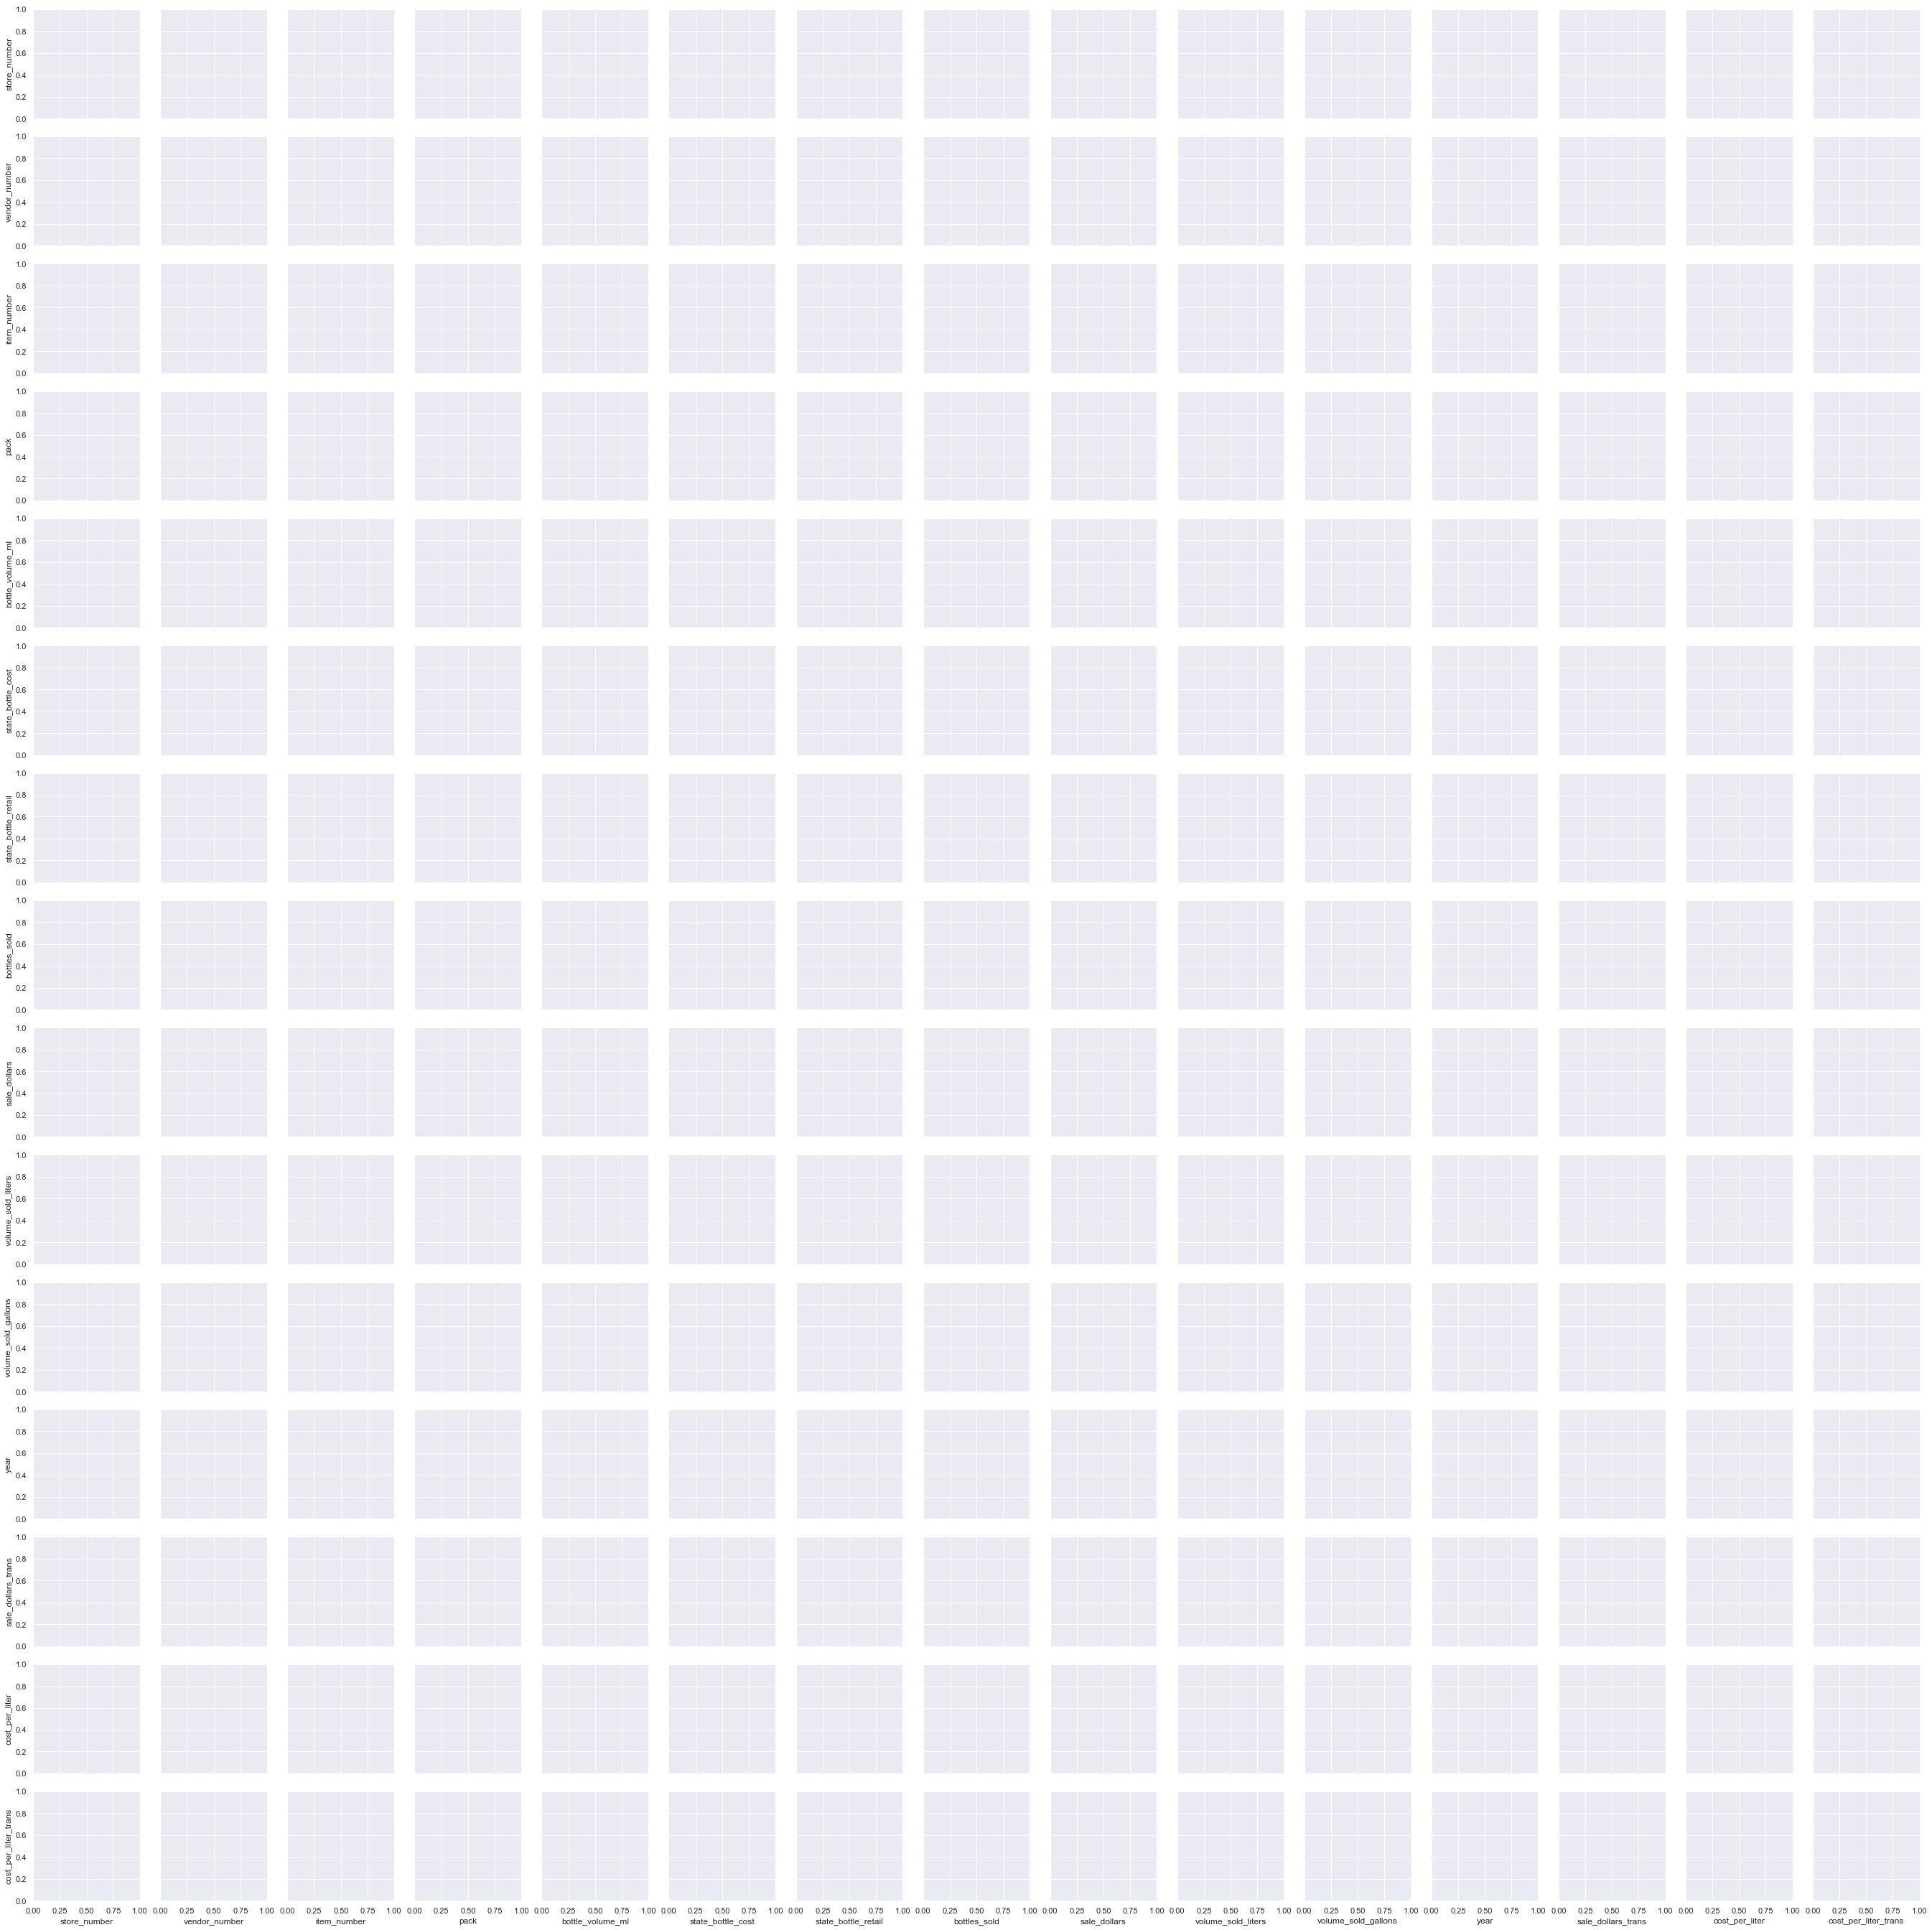

In [0]:
# now try plotting some of the previous plots, way more visually appealing!!
#https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166
sns.pairplot(df)
sns.pairplot(df, hue= 'Category')
sns.pairplot(df, hue='Category', diag_kind = 'kde')

Here we can see a couple pair scatter plots that show our coorelations in action. In the bottom right corner, we can see those same highly correlated values visualized in a plot, and broken out by drink type.

Interestingly, we can see some clustering start to appear in some of the relationships, particularly between tequila and whiskey as it relates to volume sold and sales data.

![image.png](attachment:image.png)

In [0]:
#cross tab example
dfcross = pd.crosstab(df['Category'], df['store_parent'],  margins=True, margins_name="Total")
dfcross

store_parent,CVS,Fareway,Hy-Vee,Other,Target,Wal-Mart,Total
Category,,,,,,,
GIN,8,109,1499,1391,34,60,3101
LIQUEUR,7,313,2424,3856,42,365,7007
Other,5,688,3570,4245,111,536,9155
RUM,4,205,2231,2770,18,380,5608
TEQUILA,2,89,538,849,2,66,1546
VODKA,48,534,4409,7486,93,457,13027
WHISKY,36,545,5112,4496,133,234,10556
Total,110,2483,19783,25093,433,2098,50000


Next, we are going to look at a cross tab and explore the relationships with alcohol type and store.

As you can see in the table above, Hy Vee and Other take up the majority of sales, however Other is a stronger Vodka seller while Hyvee sales more whieksy. This is confirmed below with our chart that shows the mix of alcohol sales int he story. For each, Vodka and whiskey are among the top sellers. 

In [0]:
#Normalized Cross Tab
dfcrossnorm = pd.crosstab(df['Category'], df['store_parent'], normalize='columns')
dfcrossnorm

store_parent,CVS,Fareway,Hy-Vee,Other,Target,Wal-Mart
Category,,,,,,
GIN,0.072727,0.043899,0.075772,0.055434,0.078522,0.028599
LIQUEUR,0.063636,0.126057,0.122529,0.153668,0.096998,0.173975
Other,0.045455,0.277084,0.180458,0.169171,0.256351,0.255481
RUM,0.036364,0.082561,0.112774,0.110389,0.041570,0.181125
TEQUILA,0.018182,0.035844,0.027195,0.033834,0.004619,0.031459
VODKA,0.436364,0.215062,0.222868,0.298330,0.214781,0.217827
WHISKY,0.327273,0.219493,0.258404,0.179173,0.307159,0.111535


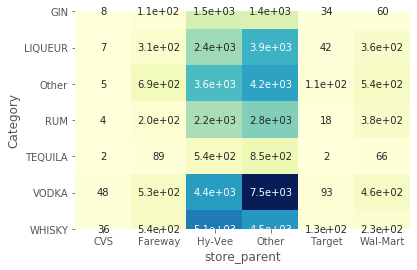

In [0]:
sns.heatmap(pd.crosstab([df['Category']], [df['store_parent']]),
            cmap="YlGnBu", annot=True, cbar=False)

Next is a heatmap which shows the relationship between Vodka and Whiskey amontst the stores, which provides a visual representaiton of the data above. 

In [0]:
#group wise average
df_grouped = df.groupby(by=['Category', 'store_parent']).mean()
df_grouped

## Explore Attributes and Class
Identify and explain interesting relationships between features and the class you are trying to predict (i.e., relationships with variables and the target classification).



## New Features 
Are there other features that could be added to the data or created from existing features? Which ones?



* Day of the week  
* education  
* median population  
* income groups  
* age groups  
* employment  
* Grouping of Liquor Brands  

We also created a series of columns which were aggregates of other columns:

* Cost Per Liter
* Total Cost
* Revenue 
* Gross Margin
* Log Transform of Sales
* Log Transform of Volume Sold

## Exceptional Work 
You have free reign to provide additional analyses. One idea: implement dimensionality reduction, then visualize and interpret the results.

### Load Data from BigQuery

In order to load in our data, we will need to create a project id and save in our .json credentials from BigQuery onto our local machine. From there, we can set the client variable to map the credentials to our service account in our bigquery program. 